<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


# eICU-CRD

All stays are centered on ICU admission (unlike MIMIC). 

<u>Data in the eICU-CRD database was collected from several hospitals.</u>

Access to the database was done through Physionet, by signing the data use agreement, as certification and credentials were already obtained for MIMIC-IV.

**<center>The following was ran and obtained on Google BigQuery.</center>**

The database has schema documentation: https://eicu-crd.mit.edu/eicutables/patient/
</div>

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
%run textColumn_analysis.ipynb

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


## Overview of the data

|  | feature name | Value |
| --- | ----------- | ----------- |
| Number of ICU stays (one patient can go through several ICUs) | `patientunitstayid` | 200 859 |
| Number of distinct hospital admissions$^*$ | `patienthealthsystemstayid` | 166 355 |
| Number of distinct ICU patients | `uniquepid` | 139 367 |

<br>

One `uniquepid` can be associated with several rows in the _patient_ table; but patients are uniquely identified by `uniquepid`. A total of **139 367** unique patient are registered with ICU stays in the database. 

One hospital stay is identified by `patienthealthsystemstayid`, and a patient with several admissions can thus have several `patienthealthsystemstayid`'s. A total of **166 355** hospital stays (uniquepid-patienthealthsystemstayid unique pair) are recorded in the database. 

**38 483** distinct patients have several icustays. 

Finally, over one hospital stay, a patient can transfer ICU unit; each stay in an ICU unit is uniquely identified by a `patientunitstayid`.
</div>


    SELECT COUNT(DISTINCT uniquepid),
      COUNT(DISTINCT patienthealthsystemstayid),
      COUNT(DISTINCT patientunitstayid)
    FROM `physionet-data.eicu_crd.patient`

<span style="color:silver">\# subquery: we select the distinct admission and patient IDs. One uniquepid may have several patienthealthsystemstayid</span>

<span style="color:silver">\# query: we group by patient id to count the number of admissions per patient. We filter to keep only patient with several admissions</span>

    SELECT uniquepid, COUNT(*) AS co
    FROM (
      SELECT uniquepid, patienthealthsystemstayid
        FROM `physionet-data.eicu_crd.patient`
    )
    GROUP BY uniquepid
    HAVING co > 1

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


- the number of hospital admissions per patient ranges from **1** to **24**, with an average of **1.2** hospital stay per patient. 
- the average number of unit stay per patient and per hospital admission (`uniquepid`-`patienthealthsystemstayid` pair) ranges from **1** to **17**, with an average of **1.2** ICU stay. **83.39%** of the patients stays in hospital are only associated with one ICU admission, **13.92%** with 2 ICU stays.
</div>

<span style="color:silver">\# number of ICU stays per patient (this groups over patientunitstayid)</span>

    SELECT uniquepid, patienthealthsystemstayid, COUNT(*) 
    FROM `physionet-data.eicu_crd.patient`
    GROUP BY uniquepid, patienthealthsystemstayid
    ORDER BY uniquepid

<span style="color:silver">\# with result from previous query</span>

<span style="color:silver">\# we compute the number of hospital stay per patient</span>

    SELECT uniquepid, COUNT(*) AS c 
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonf7ee68c06e5a782a68d3c6ffdea5f04bbc330bcf3e956f084b8faff7c3db06ac`
    GROUP BY uniquepid
    ORDER BY c DESC 

<span style="color:silver">\# with result from previous query</span>

<span style="color:silver">\# we compute the average number of hospital stay per patient</span>

    SELECT AVG(c)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon15676a1cd443f1cb799184faeb01dc33c9219b7474737cf39405e6d1e8514afc`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**Here we select the list of distinct patient and hospital stay** (one patient can have several hospital stays, and one hospital stay is <u>minimum</u> one ICU stay)
</div>

    SELECT DISTINCT uniquepid, patienthealthsystemstayid
    FROM `physionet-data.eicu_crd.patient`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

- `hospitaldischargeoffset` is never null. It corresponds to the number of minutes between hospital admission and hospital discharge
- average length of stay is **9763.67** minutes, or **6.78** fractional days.
</div>

<span style="color:silver">\# count of null hospitaldischargeoffset</span>

    SELECT DISTINCT ordercategoryname FROM `physionet-data.mimiciv_3_1_icu.procedureevents`

<span style="color:silver">\# average length of stay</span>
    SELECT AVG(hospitaldischargeoffset) FROM `physionet-data.eicu_crd.patient`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


eICU-CRD is a **multi-center** database. The data was collected in **208** distinct hospitals in **4** different regions.

(*All `hospitalid` in the* patient *table are referenced in the* hospital *table, and it is true the other way around*). 
</div>

<span style="color:silver">\# number of distinct hospital we have info about </span>

    SELECT COUNT(DISTINCT hospitalid)
    FROM `physionet-data.eicu_crd.hospital`

<span style="color:silver">\# number of distinct hospital where data was actually collected (same as above)</span>

    SELECT COUNT(DISTINCT hospitalid)
    FROM `physionet-data.eicu_crd.patient`

<span style="color:silver">\# distinct regions the data is from</span>

    SELECT COUNT(DISTINCT region)
    FROM `physionet-data.eicu_crd.hospital`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


## Patients representation

Since the _patient_ table encompasses all distinct patient, hospital stays and ICU stays, we don't perform demographic statistics for all ICU stays but rather over distinct patient-stay (`uniquepid`-`patienthealthsystemstayid` pair). For example, for `age`, the age of the patient can change from one admission to the other.

**<u>Age</u>**

Because the patient information is recorded everytime the patient is admitted in ICU, we can take the age distribution of patients as they are admitted to ICU (unlike in MIMIC-IV)

- **!!** In _patient_, `age` is a string (documentation indicates VARCHAR(10)). Null age is indicated by an empty string "" and represents only **0.05%** of the database. Patient that are more than **89** years old have age equal to "> 89" (for de-identification purposes) and represent **3.53%** of the rows. 
- Similarly, null `gender` is actually an empty string "", which represents **0.07%** of the rows. **0.017%** of the rows have "Unknown" gender
- Null `ethnicity` is an empty string as well, for **1.14%** of the rows. "Other/unknown" is **4.75%** of the rows
</div>

<span style="color:silver">\# percentage of null age in patient</span>

    SELECT 100*COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient`)
    FROM `physionet-data.eicu_crd.patient`
    WHERE age IS NULL 

<span style="color:silver">\# average excluding null age and above 89</span>

<span style="color:silver">\# because age is a string we must cast it as an integer</span>

    SELECT AVG(CAST(age AS int))
    FROM `physionet-data.eicu_crd.patient`
    WHERE age != "" AND age != "> 89"

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


- The first query returns 166 355 rows, indicating that there is no inconsistency of age accross ICU stays

To look at age distribution, we only consider hospital stays (and not disinct patients only), as a patient that comes several times can be aged differently at his different hospital admissions.

- **0.05%** have null age (empty string), **3.66%** have age equal to "> 89". 
- **0.286%** or **476** patients are under 18.
</div>

In [74]:
df_admission_age = pd.read_csv("../Data/eICU-CRD/admissions_Age.csv").dropna()

for index, datapoint in df_admission_age.iterrows() :
    if datapoint["age"] == "> 89" :
        df_admission_age.loc[index, "age"] = 89
    else :
        df_admission_age.loc[index, "age"] = int(df_admission_age.loc[index, "age"])

df_admission_age
# print(np.mean(admission_age), np.quartile(admission_age, 0.25), np.quartile(admission_age,0.75))

,patienthealthsystemstayid,uniquepid,age
40,1014888,013-27781,27
60,2253390,027-116986,23
80,1116627,015-93748,22
81,2154643,027-99100,20
82,1568070,021-122024,21
...,...,...,...
166350,816335,010-23,89
166351,809666,010-13,89
166352,834609,010-132,89
166353,843230,010-169,89


In [75]:
admission_age = df_admission_age["age"]
print("median, 25th quantile and 75th quantile")
print(np.median(admission_age), np.quantile(admission_age, 0.25), np.quantile(admission_age, 0.75))
print("mean", np.mean(admission_age))

median, 25th quantile and 75th quantile
65.0 52.0 76.0
mean 62.88132025428367


proportion of children 0.2862796278364838


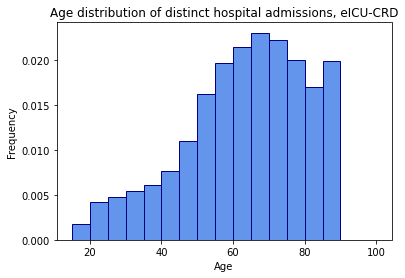

In [76]:
print("proportion of children", 100*len(admission_age[admission_age < 18])/len(admission_age))
bins = [5*k for k in range(3,21)]
age_admission_plot = plt.hist(admission_age, bins=bins, edgecolor='navy', color='cornflowerblue', density=True)
plt.title("Age distribution of distinct hospital admissions, eICU-CRD")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

<span style="color:silver">\# count the number of patient-age tuples</span>

    SELECT DISTINCT uniquepid, patienthealthsystemstayid, age
    FROM `physionet-data.eicu_crd.patient`

<span style="color:silver">\# with result from above query</span>

<span style="color:silver">\# age and their frequency in hospital admissions </span>

    SELECT age, 100*COUNT(*)/166355 AS percentage
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonad2aaa39d778090a55f706a0ab88f191af1dae7270a5eb9c33bfaea516829ead`
    GROUP BY age

<span style="color:silver">\# frequencies of childrens </span>

    SELECT * 
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonad2aaa39d778090a55f706a0ab88f191af1dae7270a5eb9c33bfaea516829ead` 
    WHERE age != "" 
      AND age != "> 89"
      AND CAST(age AS int) < 18

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


Instead of computing age statistic by removing "> 89", we replace it with "89" to have a better approximate of the average age.
</div>

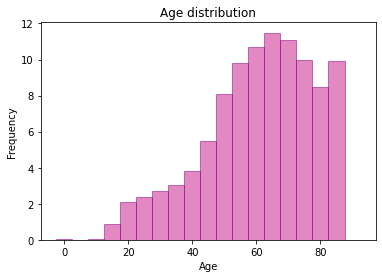

In [31]:
df_patient_age = pd.read_csv("../Data/eICU-CRD/patient_age_count.csv")

# here we add the "> 89" percentage to the "89" value and we remove the last row
row = { "age": "89", "percentage": df_patient_age["percentage"].loc[90]+df_patient_age["percentage"].loc[91] }
df_patient_age.loc[90] = row
df_patient_age = df_patient_age.drop([91])

# first we group ages by 5 and compute their associated frequency
bins = np.linspace(0,90,19)
count = [0 for i in range(19)]

for index, datapoint in df_patient_age.dropna().iterrows() :
    count[int(datapoint["age"])//5] += datapoint["percentage"]

plt.bar(bins, count, width=5, edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [46]:
df_age_int = df_patient_age.dropna() 

# from this we can re-compute age average:
avg_age = 0
for index, datapoint in df_age_int.iterrows() :
    df_age_int.loc[index, "age"] = int(df_age_int.loc[index, "age"])
    avg_age += datapoint["percentage"]*int(datapoint["age"])
avg_age = avg_age/len(df_age_int)
print("Average age in eICU-CRD couting all patient > 89 as 89 is", avg_age)

df_minors = df_age_int["percentage"].loc[ df_age_int["age"] < 18 ]
df_minors
print("The percentage of childrens is", sum( df_age_int["percentage"].loc[ df_age_int["age"] < 18 ]))

Average age in eICU-CRD couting all patient > 89 as 89 is 69.83285410384089
The percentage of childrens is 0.2861350725857345


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Gender</u>**
</div>

<span style="color:silver">\# gender and their frequency in patient across all ICU stays</span>

    SELECT gender, 100*COUNT(*)/(SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient`)
    FROM `physionet-data.eicu_crd.patient`
    GROUP BY gender

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


- The first query returns 166 355, which is extacly the number of unique hospital stays; thus there is no inconsistency in the gender indicated in the database across ICU stays 
- However when grouping by `uniquepid`-`gender`, we obtain **139 393**, so there are **26** inconsistencies between the patient and their gender. All of these inconsistencies except for 004-5716, 017-11051, 027-150454, 031-2559 (male-female) and 032-30969 (male-other) correspond to null values, but as they are recorded several times in the database, we still have ther rows indicating their gender. These 26 patients are associated with **84** hosital admissions, which corresponds to 0.05%. <u>We consider this as neglectable and we proceed to statistics on gender</u>.

`list_gender_inconsistency` is the list of all `uniquepid` with a gender inconsistency.


- When taking several hospital admissions into account (_if a women is admitted twice to the hospital, then we count twice her gender as a woman_), we have **53.75%** of men, **46.17%** of women, **0.07%** of null (empty string), **0.02** of "Unknown" and less than 0.01% for "Other"
- when taking gender of distinct patients, removign the 26 patients that have erroneous genders (so across 139 367 distinct patients that have been at least once in ICU), we have **53.95%** of men, **45.95%** of women, **0.07%** of null (empty string), **0.02%** of "Unknown" and  less than 0.01% for "Other"
</div>

<span style="color:silver">\# query 1)</span>

<span style="color:silver">\# gender of patients in hospital admissions across stays is the same across icu stays</span>

    SELECT DISTINCT uniquepid, patienthealthsystemstayid, gender
    FROM `physionet-data.eicu_crd.patient` 

<span style="color:silver">\# query 2)</span>

<span style="color:silver">\# with table from above query. We check the consistency of gender across admissions. The number of rows in result table is bigger than the number of patients</span>

    SELECT DISTINCT uniquepid, gender 
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`

<span style="color:silver">\# from query 1, we obtain the different genders and their frequency across hospital admissions (not across patients)</span>

    SELECT gender, COUNT(*)/(SELECT COUNT(*) FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d14378`
    GROUP BY gender

<span style="color:silver">\# with result table from query 2</span>

<span style="color:silver">\# we obtain the patients that appear with different genders</span>

    SELECT uniquepid, COUNT(*) AS c 
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anone8e87d2ca14103b09cb0fc1c4bd87d1605d1766ab703e11559736224f2aec29e`
    GROUP BY uniquepid
    HAVING c > 1

<span style="color:silver">\# here we select the unique patients and their gender. For all patients that do not appear with several gender indications</span>

    SELECT * 
    FROM (
      SELECT DISTINCT uniquepid, gender
      FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon6ea4126e36c78fd6853dd8c25adbdeacf70a19a9f587f778dbbd1e7d30d1437`
    ) A 
    LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anone98af1379df5cff9f82fb11058a3518f4c92cc80a683b3b0012c087869fb0e1f` B
    ON A.uniquepid=B.uniquepid
    WHERE B.uniquepid IS NULL
    
<span style="color:silver">\# from the result of this query, we obtain the percentage of genders</span>

In [231]:
# the uniquepid with gender inconsistencies
list_gender_inconsistency = [
    "002-50226","002-66204","003-44255","004-12627","004-18621",
    "004-42773","004-5716","004-72315","004-86879","008-20478",
    "008-5728","009-16546","009-7445","017-11051","017-1482",
    "017-59827","017-73098","017-90100","021-144703","024-4709",
    "027-150454","027-165386","027-97252","031-2559","032-30969","004-93515",
]

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


`age` distribution per `gender`. By only selecting "Female" and "Male" we obtain the histogram for 160 132 rows. Then we select the rows for which the gender is "Other" but we don't take into account the rows for which the gender is an empty string or "unknown". Again, we also remove the rows for age "> 89".
</div>

In [236]:
df_age_gender = pd.read_csv("../Data/eICU-CRD/patient-admission_age_gender.csv")
F = pd.DataFrame(df_age_gender.loc[ (df_age_gender["gender"]=="Female")&(df_age_gender["age"]!="> 89") ]["age"]).dropna()
M = pd.DataFrame(df_age_gender.loc[ (df_age_gender["gender"]=="Male")&(df_age_gender["age"]!="> 89") ]["age"]).dropna()
O = df_age_gender.loc[ (df_age_gender["gender"]=="Other") ].dropna()
F["age"]=pd.to_numeric(F['age'])
M["age"]=pd.to_numeric(M['age'])

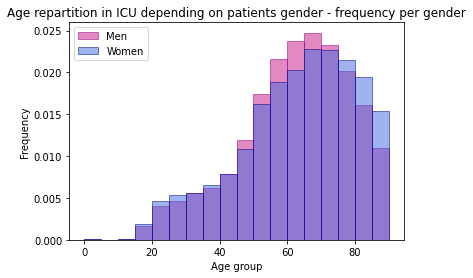

In [237]:
bins = np.linspace(0,90, 19)
plt.hist(M["age"], bins=bins, label="Men", edgecolor='darkmagenta', color='mediumvioletred', alpha=0.5, density=True)
plt.hist(F["age"], bins=bins, label="Women", edgecolor='navy', color='royalblue', alpha=0.5, density=True)
plt.legend()
plt.xlabel("Age group")
plt.ylabel("Frequency")
plt.title("Age repartition in ICU depending on patients gender - frequency per gender")
plt.show()

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


### <u>patient</u> 

**200 859** rows, which correspond to **200 859** ICU admissions.

<u>Primary key of _patient_:</u> `patientunitstayid` identifies unit stays. It is the main key for linking data to a unit stay across all tables. 

</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


**<u>Ethnicity</u>**

- First we look at the `ethnicity` of the distinct patients. However the query results in **140 100 rows**: **22** patients have 3 different ethinicities indicated (_it might correspond to more rows than 3, for example if a patient is indicated twice a Caucasian, once as hispanic and once as unknown_), and **689** patients have 2 ethnicities indicated. Among these errors, only 107 correspond to an ethnicity indication + a null value; the rest indicates two different ethnicities (_ex: Hispanic and Caucasian_), which may include "Other/unknown". 

- To compute ethnicity frequency, we first remove all 711 patients from the list of distinct patients, which gives **138 656** distinct patients. 
- Then we compute the race frequency accross admissions rather than patients: a caucasian patient admitted twice will count twice towards the frequency. We first remove all rows associated with patients that have several ethnicities indicated, we obtain **164 438** rows. 
</div>

<span style="color:silver">\# distinct patient-ethnicity tuples</span>

<span style="color:silver">\# if no problem, this should result in the same number of rows as the number of patients. But higher number of resulting rows</span>

    SELECT DISTINCT uniquepid, ethnicity
    FROM `physionet-data.eicu_crd.patient`

<span style="color:silver">\# query 2)</span>

<span style="color:silver">\# with result from above query: number of ethnicities registered per patient</span>

    SELECT uniquepid, COUNT(*) AS co
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon910e5217904cd318d4511da40a5214bfb2d8fa52b046850cbcabd0e9392256c1`
    GROUP BY uniquepid
    ORDER BY co DESC

<span style="color:silver">\# with result from above query</span>

<span style="color:silver">\# in the subquery we select the patients that have several ethnicities indicated. We get all patient and their different ethinicities when inconsistencies</span>

    SELECT DISTINCT P.uniquepid, P.ethnicity
    FROM `physionet-data.eicu_crd.patient` P
    LEFT JOIN (
      SELECT uniquepid 
      FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona50aa284e19f32a351e1f53a3064a987b4a83d4d1c141af7cf82e01bad1f37eb` 
      WHERE co > 1) E
    ON P.uniquepid=E.uniquepid
    WHERE E.uniquepid IS NULL 
    ORDER BY uniquepid

<span style="color:silver">\# with table from query 2</span>

<span style="color:silver">\# this query returns all patient and their ethnicity that are consistent</span>

    SELECT P.uniquepid, P.ethnicity
    FROM (SELECT DISTINCT uniquepid, patienthealthsystemstayid,ethnicity FROM `physionet-data.eicu_crd.patient`) P
    LEFT JOIN (
      SELECT uniquepid 
      FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona50aa284e19f32a351e1f53a3064a987b4a83d4d1c141af7cf82e01bad1f37eb` 
      WHERE co > 1) E
    ON P.uniquepid=E.uniquepid
    WHERE E.uniquepid IS NULL 
    ORDER BY uniquepid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


Here we compute the frequency of ethnicities among the <u>distinct</u> patients.

**`df_distinct_patient_ethnicity` is the csv file of all distinct patients' ethnicity and the frequency. `df_distinct_patientadmission_ethnicity` is the csv file of patients' ethnicity counting for the several admissions in hospital** (the ethnicity of a patient admitted twice in the hospital will count twice in the frequency).

</div>

In [239]:
df_distinct_patient_ethnicity = pd.read_csv("../Data/eICU-CRD/patient_ethnicity_percentage.csv")
df_distinct_patient_ethnicity

,ethnicity,co
0,Caucasian,77.488893
1,African American,10.544802
2,Asian,1.652291
3,Hispanic,3.719276
4,NaN,1.249135
5,Native American,0.689476
6,Other/Unknown,4.656127


In [240]:
df_distinct_patientadmission_ethnicity = pd.read_csv("../Data/eICU-CRD/patientadmission_ethnicity_percentage.csv")
df_distinct_patientadmission_ethnicity

,ethnicity,f0_
0,Caucasian,77.372019
1,African American,11.056447
2,Asian,1.599387
3,Hispanic,3.672509
4,NaN,1.185249
5,Native American,0.723677
6,Other/Unknown,4.390713


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


**<u>Death representation</u>**

Death indication can be found in the _patient_ table:
- `hospitaldischargelocation` and `hospitaldischargestatus` indicate the death data (or not) on the totality of the hospital stay
- `unitdischargelocation` and `unitdischargestatus` indicate the same data but for an ICU stay

For each of these 4 features, there are never null values, but <u>empty strings</u>.

Hospital stay, `hospitaldischargelocation` (*we perform our analysis over the 166 355 distinct `patienthealthsystemstayid`, ohterwise the values for patients who had several ICU stays would be counted several times ; here we are interested in the outcomes of the hospital admissions*).

- no inconsistencies between `patienthealthsystemstayid` and `hospitaldischargelocation` (verification query returns 166 355 rows)
- **1.02%** or **1 697** rows of `hospitaldischargelocation` rows are null.
- **14 623** or **8.79%** of the hospital admission indicate "Death" of patient for `hospitaldischargelocation`
- **8.79%** of the rows indicate "Expired" for `hospitaldischargestatus`, and correspond exactly to the rows where discharge location is "Death" (**`hospitaldischargestatus` and `hospitaldischargelocation` are always consistent**).

Hospital stay, `hospitaldischargestatus`

- no inconsistencies between `patienthealthsystemstayid` and `hospitaldischargestatus` (verification query returns 166 355 rows)
- **1 480** rows or **0.89%** of hospital admissions have null hospital discharge status (corresponds exactly to the rows where discharge location is null)
- **14 623** or **8.79%** of hospital admissions (`patienthealthsystemstayid`) have a status of "Expired"
</div>

<span style="color:silver">\# verification query</span>

<span style="color:silver">\# (works since all patientunitstayid should have the same hospitaldischargelocation). We perform the same query with hospitaldischargestatus</span>

    SELECT patienthealthsystemstayid, hospitaldischargelocation, COUNT(*)
    FROM `physionet-data.eicu_crd.patient`
    GROUP BY patienthealthsystemstayid, hospitaldischargelocation

<span style="color:silver">\# validation query</span>

<span style="color:silver">\# exact correspondance for death in hospital discharge location and status</span>

    SELECT COUNT(*)
    FROM `physionet-data.eicu_crd.patient`
    WHERE hospitaldischargelocation="Death"
      AND hospitaldischargestatus="Expired"
    
<span style="color:silver">\# verification query</span>

<span style="color:silver">\# 166 355 resulting row confirm that discharge status and location are always consistent</span>

    SELECT DISTINCT patienthealthsystemstayid, hospitaldischargestatus, hospitaldischargelocation
    FROM `physionet-data.eicu_crd.patient`
    ORDER BY patienthealthsystemstayid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


ICU `unitdischargelocation`
- **334** or **0.17%** of the `patientunitstayid` have empty string (not null!) `unitdischargelocation`
- **10 907** or **5.43%** of "Death" for discharge location 


ICU `unitdischargestatus`
- **34** or **0.02%** of empty string (not null!) discharge status 
- **10 907** or **5.43** of "Expired" discharge status


- `unitdischargelocation`="Expired" and `unitdischargestatus`="Death" always coincide (**10 907** `patientunitstayid`)

We check and confirmed that no patient dies within two units (`unitdischargestatus`).
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


*Since `hospitaldischargestatus` and `hospitaldischargelocation`, and `unitdischargestatus` and `unitdischargelocation` are always consistent, we will only use the status in the following comparison*.

Observe that, because the hospital discharge status indicates the outcome of the hospital stay, whereas the unit discharge status only indicate the specific unit discharge, `hospitaldischargestatus` can be "Expired" but not `unitdischargestatus` (in case the patient died in another unit). This is true for **7 319** rows in _patient_. 

- There are **222** inconsistencies in _patient_ where `unitdischargestatus` indicates "Expired" but not `hospitaldischargestatus`
    - **167** rows where `unitdischargestatus` = "Expired" but `hospitaldischargestatus` = "Alive"
    - **55** rows where `unitdischargestatus` = "Expired" but `hospitaldischargestatus` = "" 
</div>

    SELECT patienthealthsystemstayid, patientunitstayid, hospitaldischargestatus, unitdischargestatus
    FROM `physionet-data.eicu_crd.patient`
    WHERE hospitaldischargestatus!="Expired"
    AND unitdischargestatus = "Expired"

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


- `actualicumortality` only takes as value "Expired" or "Alive"
- in the _apachepatientresult_ table, the `actualicumortality` indicates "EXPIRED" in case of death of the patient. Note that **148 532** `patientunitstayid` have 2 rows (no more) in this table, for APACHE score with version IV <u>and</u> IVa (_by selecting all rows of `patientunitstayid` that have two rows, and counting distinct `patientunitstayid`-`actualicumortality`, we obtain **148 532** resulting rows, thus checking that when a `patientunitstayid` has two rows, `actualicumortality` is always consistent_).
- **52 327** `patientunitstayid` have no associated data in _apachepatientresult_ (*the 148 532 other do have data, as mentionned above, and we deduce that any patient with apache data has the two different scores indicated in the table*)
- **8 615** `patientunitstayid` have `actualicumortality`="Expired"
</div>

<span style="color:silver">\# selecting patient icu stays and their actual mortality, for patient that have apache data</span>

    SELECT DISTINCT patientunitstayid, actualicumortality
    FROM `physionet-data.eicu_crd.apachepatientresult`

<span style="color:silver">\# with result from previous query</span>

<span style="color:silver">\# performing a left join allows us to identify patient that don't have apache data in apachepatientresult</span>

    SELECT P.patientunitstayid, A.*
    FROM `physionet-data.eicu_crd.patient` P
    LEFT JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona8fdac2af2ff81def61eb389b0ac55f8b7c3c64dc9ac639186bdafdf36741af9` A
    ON P.patientunitstayid=A.patientunitstayid

<span style="color:silver">\# with result from above query</span>

<span style="color:silver">\# count of the number of patientunitstayid with no apache data in apachepatientresult</span>

    SELECT COUNT(*)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon5c4bb05401517912bca21c89503b61d5ad74eadf1b7b1dfe9fa9599383a6188b`
    WHERE patientunitstayid_1 IS NULL 

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


No we compare the hospital and ICU discharge status and the `actualicumortality` data (*this is possible only for the **148 532** `patientunitstayid` that have data in* apachepatientresult).

- `actualicumortality` and `unitdischargestatus` are always consistent when equal to "Expired" (8 615 rows)
- for the 139 917 rows where `actualicumortality` = "ALIVE", only **10** rows have `unitdischargestatus` = "" and the rest is "Alive" so it coincindes. 

</div>

<span style="color:silver">\# join to obtain the comparison of all death indicators</span>

<span style="color:silver">\# we indeed obtain 148 532 rows. We use the result of this query for our comparison</span>

    SELECT A.*, P.hospitaldischargestatus, unitdischargestatus
    FROM (
      SELECT DISTINCT patientunitstayid, actualicumortality
      FROM `physionet-data.eicu_crd.apachepatientresult`
    ) A JOIN `physionet-data.eicu_crd.patient` P
    ON A.patientunitstayid = P.patientunitstayid

<span style="color:silver">\# With result from above query. We compare the icu mortality</span>

    SELECT *
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon16a2d08e5f973c06a85d3eb68b9d9577e0ec287654e4a13103647d621298bda9`
    WHERE unitdischargestatus != actualicumortality

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Medical history</u>**

Unlike in MIMIC-IV (if not for previous registered hospital admissions), eICU-CRD provides information about the medical history (_pasthistory table_) of the patient, and allergies (_allergy_ table).

- _allergy_, for detected allergies during the stay. Each row indicates the "nature" of the allergy recorded ("Admission", "Re-Admission", "Daily Progress", etc), whether it is to a drug or not. *Observe that the absence of observation does not indicate an absence of allergy*
    - **251 949** rows 
    - **137 109** don't have any allergies recorded, **63 750** do have some allergies recorded (*and indeed summing gives 200 859*)
    - Each declaration of an allergy is linked with an ICU stay and corresponds to 1 row, thus a unique `patientunitstayid` may have several allergies recorded, ranging from **2** to **957** with an average of **5.98** rows per `patientunitstayid` (counting only `patientunitstayid` that have allergies recorded)
    
**`df_allergy` is the loaded csv file of all allergy names and their frequency in the _allergy_ table**.
- 121 extra space problems
- we observe that a lot of the variables have a "jump" at the end of the string (*this might be due to storing in cells or the way data is entered into the system?)*

</div>

<span style="color:silver">\# allergies </span>

    SELECT patientunitstayid, COUNT(*) AS co
    FROM `physionet-data.eicu_crd.allergy`
    GROUP BY patientunitstayid
    HAVING co > 1

In [13]:
%run textColumn_analysis.ipynb

In [10]:
df_allergy = pd.read_csv("../Data/eICU-CRD/allergy_name.csv")
extrasp_df = countExtraSpaces(df_allergy, "allergyname")["list_df_diff_nosp"]
countExtraSpaces(df_allergy, "allergyname")

{'initial_count': 10897,
 'nospace_count': 10776,
 'diff_distinct_nosp': 121,
 'list_df_diff_nosp': ['morphine                                                                                                                                                                                                                                                       ',
  'see cerner                                                                                                                                                                                                                                                     ',
  'See Cerner                                                                                                                                                                                                                                                     ',
  'cerner                                                                                                             

In [14]:
countCapitalization(df_allergy, "allergyname")

{'initial_count': 10897,
 'decap_count': 7904,
 'diff_distinct_decap': 2993,
 'list_df_diff_cap': ['aspirin                                                                                                                                                                                                                                                        ',
  'motrin                                                                                                                                                                                                                                                         ',
  'morphine                                                                                                                                                                                                                                                       ',
  'levaquin                                                                                                             

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

- _pasthistory_, providing history about patients. The table is not very detailed but provides essential information such as AIDs, transplants, chronic renal failure, etc
    - the table contains **1 149 180** rows, for **176 258** distinct `patientunitstayid`, corresponding to **161 925** distinct `patienthealthsystemstayid`
    - redundancy of information (<mark>functional dependency</mark>), because the field `pasthistoryvalue` is equal to the field `pasthistoryvaluetext` for **1 123 127** of the rows, that is, only **2.32%** of the rows have different values for these fields. Moreover the only rows where they are different actually only differ by a space: the value taken by `pasthistoryvaluetext` is either "NotPerformed", "NotObtainable" or "NoHealthProblems", whereas it is respectively "Not Performed", "Not Obtainable" and "No Health Problems" for `pasthistoryvalue`.
    - `pasthistoryvalue` takes only **224** distinct values, including the ones mentionned above
    - among the distinct values of `pasthistoryvalue` (and thus of `pasthistoryvaluetext` by equality of the fields), the most frequent ones are "Performed" (**24.78%**) and "hypertension requiring treatment" (**13.92%**) (the rest of the vales represent less than 4% of the rows, "insulin dependent diabetes" is for example **3.75%**)


- _admissiondrug_, **874 920** rows ; (not very frequently indicated, only for **40 740** or **20.28%** of the `patientunitstayid`, and **37 554** or **22.57%** of the `patienthealthsystemstayid`) indicates the drugs taken by the patient prior to admission to the ICU 
    - 19 distinct `drugunit , including "mg" and "micrograms" ; null (empty string) **72.76%** of the rows
    - `drugadmitfrequency` null (empty string) **638 951** or **73.03%** of the rows
</div>

<span style="color:silver">\# distinct hospital admissions that have past history values </span>

    SELECT COUNT(DISTINCT patienthealthsystemstayid)
    FROM `physionet-data.eicu_crd.pasthistory` H
    JOIN `physionet-data.eicu_crd.patient` P
    ON H.patientunitstayid = P.patientunitstayid

<span style="color:silver">\# comparison of past history value and valuetext</span>

    SELECT *
    FROM `physionet-data.eicu_crd.pasthistory`
    WHERE pasthistoryvalue = pasthistoryvaluetext

    SELECT DISTINCT pasthistoryvalue, pasthistoryvaluetext
    FROM `physionet-data.eicu_crd.pasthistory`
    WHERE pasthistoryvalue != pasthistoryvaluetext

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### Diagnoses representation

Diagnoses in eICU-CRD are indicated in several places:
- in the _diagnosis_ table, using a string in the icd 9 code
- in the _patient_ table, where diagnosis upon admission is indicated by `apacheadmissiondx`

**In the <u>_diagnosis_</u> table** (join on `patientunitstayid`):

- **2,710,672** rows
- `diagnosisstring` and `icd9code` are never null
- **BUT** `icd9code` can be equal to the empty string, which is not considered as "NULL" by SQL but is indeed a null value. This regards **431 959** rows, or **15.94%** of the rows.
- `diagnosisstring` is never an empty string
- **27 750** `patientunitstayid` don't have a diagnosis
- **8 774** admissions (`patienthealthsystemstayid`) don't have associated diagnosis in the _diagnosis_ table

Number of diagnosis per hospital admission (`patienthealthsystemstayid`) ranges from **1** to **4 247** with an average of **17.20**. **157 581** distinct hospital admissions have at least one diagnosis (*and summing with the previously found number of admissions that don't, we indeed obtain 166 355*). 

However:
- **3 933** diagnosis names (`diagnosisstring`) for **1 209** diagnosis codes (`icd9code`): note that the icd 9 code can have added specificities in the string, for example both *burns/trauma|burns|burn injury|60-69 % of body surface* and *burns/trauma|burns|burn injury|80-89 % of body surface* have code 946.0. 
</div>

<span style="color:silver">\# query to identify patientunitstayid that don't have a diagnosis</span>

    SELECT COUNT(*)
    FROM `physionet-data.eicu_crd.diagnosis` D
    RIGHT JOIN `physionet-data.eicu_crd.patient` P
    ON D.patientunitstayid=P.patientunitstayid
    WHERE D.diagnosisid IS NULL 

<span style="color:silver">\# count of diagnosis, by their title and their code</span>

    SELECT COUNT(DISTINCT diagnosisstring), COUNT(DISTINCT icd9code)
    FROM `physionet-data.eicu_crd.diagnosis`

<span style="color:silver">\# empty string for icd 9 code</span>

    SELECT COUNT(*)
    FROM `physionet-data.eicu_crd.diagnosis`
    WHERE icd9code = ""

<span style="color:silver">\# null values</span>

    SELECT COUNT(*) FROM `physionet-data.eicu_crd.diagnosis` WHERE diagnosisstring IS NULL ;
    SELECT COUNT(*) FROM `physionet-data.eicu_crd.diagnosis` WHERE icd9code IS NULL 

<span style="color:silver">\# patientunitstayid that don't have any diagnosis</span>

    SELECT patientunitstayid
    FROM `physionet-data.eicu_crd.diagnosis` D
    RIGHT JOIN `physionet-data.eicu_crd.patient` P
    ON D.patientunitstayid=P.patientunitstayid
    WHERE D.diagnosisid IS NULL 

<span style="color:silver">\# patient admission (patienthealthsystemstayid) that don't have any diagnosis in the diagnosis_icd table</span>

<span style="color:silver">\# table 1 is the number of patientunitstayid per admission, table 2 is the number of null diagnosis rows (each diagnosis being associated with a patientunitstayid) per admission</span>

<span style="color:silver">\# we perform a join on patienthealthsystemstayid and we keep rows where count values are the same in both table. This means that the patienthealthsystemstayid has no diagnosis associated with its admission (no diagnosis for all of the ICU stays)</span>

    SELECT *
    FROM ( 
      SELECT patienthealthsystemstayid, COUNT(*) AS c1
      FROM `physionet-data.eicu_crd.patient` P
      GROUP BY patienthealthsystemstayid
    ) T1 JOIN (
      SELECT patienthealthsystemstayid, COUNT(*) AS c2
      FROM `physionet-data.eicu_crd.diagnosis` D
      RIGHT JOIN `physionet-data.eicu_crd.patient` P
      ON D.patientunitstayid=P.patientunitstayid
      WHERE D.diagnosisid IS NULL 
      GROUP BY `patienthealthsystemstayid`  
    ) T2
    ON T1.patienthealthsystemstayid = T2.patienthealthsystemstayid
    WHERE T1.c1 = T2.c2

<span style="color:silver">\# verification query with result from above query. We indeed obtain no data to display </span>

    SELECT *
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonc2af96f8cf7ac0354fde36bec6483fdb295760d29665e28535e9a5da7dc37648` ND
    JOIN `physionet-data.eicu_crd.patient` P ON ND.patienthealthsystemstayid=P.patienthealthsystemstayid
    JOIN `physionet-data.eicu_crd.diagnosis` D ON P.patientunitstayid=D.patientunitstayid

<span style="color:silver">\# number of diagnosis row per patient FOR PATIENTS who do have diagnosis data</span>
    
    SELECT D.diagnosisid, P.patientunitstayid, P.patienthealthsystemstayid
    FROM `physionet-data.eicu_crd.diagnosis` D
    JOIN `physionet-data.eicu_crd.patient` P
    ON D.patientunitstayid = P.patientunitstayid
    
<span style="color:silver">\# with result from above query</span>

    SELECT patienthealthsystemstayid, COUNT(*)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anona78c97dd35b5e8f781f0232ec902e91a8ac10b559fe775a5282ce3bb24b89a2e`
    GROUP BY patienthealthsystemstayid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**`df_diagnosis_string` is the loaded csv file of all distinct `diagnosisstring` values in the _diagnosis_ table.**

- 0 problem of capitalization in `diagnosisstring`
- 0 extra space problem
- we run the _detecttTypos_ function and obtain 3 922 potential typos with the default values for the different threshold. As we observe that length of diagnosis tends to be quite big (so the ratio will tend to be higher if the strings have similiarities), we filter the potential typos on the levensthein ratio with a minimum of 95. aWe obtain 1 599 filtered potential typos, that we manually check.
- diagnosis are very precise, but do not contain any typos (they do indicate concentration, severity (mild, severe, moderate), exact places (upper, lower, left, right), systematic or viral infection, etc). Hence the high ressemblance between a lot of them. 

The `diagnosisstring` column appears to be clean.
</div>

In [414]:
df_diagnosis_string = pd.read_csv("../Data/eICU-CRD/diagnosisstringDISTINCT.csv")
countCapitalization(df_diagnosis_string, "diagnosisstring")
countExtraSpaces(df_diagnosis_string, "diagnosisstring")
sus_dgn_string = detectTypos(df_diagnosis_string, "diagnosisstring", distance_threshold = 0.1)

In [422]:
# especially because the length of the strings are quite long, we increase the thresholds for detection
filtered_sus_dgn_string = sus_dgn_string[(sus_dgn_string["simple_ratio"]>=95) | (sus_dgn_string["token_sort_ratio"]>=95) | (sus_dgn_string["token_set_ratio"]>=95) ]
print("After filtering, we obtain", len(filtered_sus_dgn_string), "potential typo detection")
for index, datapoint in filtered_sus_dgn_string.iterrows() : 
    print("s1", datapoint["s1"])
    print("s2", datapoint["s2"])

After filtering, we obtain 1599 potential typo detection
s1 infectious diseases|vascular infections|endocarditis - prosthetic valve|culture pending
s2 infectious diseases|vascular infections|endocarditis - native valve|culture pending
s1 burns/trauma|burns|burn of leg
s2 burns/trauma|burns|burn of lung
s1 infectious diseases|chest/pulmonary infections|pneumonia|opportunistic|mycobacterial|mtb
s2 infectious diseases|chest/pulmonary infections|pneumonia|opportunistic|mycobacterial
s1 obstetrics/gynecology|delivery/indication for care|complication of labor/delivery|other complication of labor/delivery
s2 obstetrics/gynecology|delivery/indication for care|complication of labor/delivery|retain placenta w/o hemorrhage
s1 transplant|s/p kidney transplant|renal artery thrombosis - kidney transplant
s2 transplant|s/p kidney transplant|renal vein thrombosis - kidney transplant
s1 surgery|neurosurgical issues|neuosurgical bleeding|possible coagulopathy present
s2 surgery|neurosurgical issues|neuo

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**In the <u>_patient_</u> table** (admission diagnosis for patient unit stay)

- 200 859 rows in _patient_ so 200 859 diagnosis 
- `apacheadmissiondx` is never null

However:
- **22 996** rows have `apacheadmissiondx` equal to null string, which represents **11.45%** of empty diagnoses for an ICU stay (because in _patient_, each row where `apacheadmissiondx` is null corresponds to an ICU stay)
- 0 capitalization problem
- 0 extra space problem
- **1** typo ("chest/thorax only trauma" and "chest thorax only trauma")

Then we compute the number of patient admission (not by `patientunitstayid` but by `patienthealthsystemstayid`) that don't have any diagnosis upon hospital (not ICU) admission 
- **3 243** admissions (`patienthealthsystemstayid`) have no diagnosis (`apacheadmissiondx`) 

**`df_diagnoses` is the csv file of distinct illnesses diagnoses (including null) in _patient_ (`apacheadmissiondx`) and their frequency of diagnosis**.
</div>

<span style="color:silver">\# null values </span>

    SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient` WHERE apacheadmissiondx IS NULL ;
    SELECT COUNT(*) FROM `physionet-data.eicu_crd.patient` WHERE apacheadmissiondx = "" ;

<span style="color:silver">\# table to find patient that don't have any diagnosis upon admission in hospital (in the different icu)</span>

<span style="color:silver">\# table 1 is the number of rows (ICU stay) for each admission, table 2 is the number of rows with empty diagnosis for each admission that have at least one empty diagnosis. If those two numbers are the same it means the admission has no associated diagnosis </span>

    SELECT * 
    FROM (
      SELECT patienthealthsystemstayid, COUNT(*) AS c1
      FROM `physionet-data.eicu_crd.patient`
      GROUP BY patienthealthsystemstayid) T1
    JOIN (
      SELECT patienthealthsystemstayid, COUNT(*) AS c2
      FROM `physionet-data.eicu_crd.patient` P
      WHERE apacheadmissiondx = ""
      GROUP BY patienthealthsystemstayid
    ) T2
    ON T1.patienthealthsystemstayid = T2.patienthealthsystemstayid
    WHERE T1.c1 = T2.c2

<span style="color:silver">\# verification query</span>

<span style="color:silver">\# for all admission from the above resulting table, we join on the patient table and look for rows with diagnosis. We indeed obtain no data to display</span>

    SELECT *
    FROM `physionet-data.eicu_crd.patient` P 
    JOIN `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon9c2190745b82ebb813cc63c1cc30b7e5c546f7441a387bf4176f9a92391a0001` D
    ON P.patienthealthsystemstayid=D.patienthealthsystemstayid
    WHERE apacheadmissiondx != ""

In [426]:
df_diagnoses = pd.read_csv("../Data/eICU-CRD/patient_admission_diagnoses.csv")
print("There are", len(df_diagnoses), "distinct diagnoses upon admission (apacheadmissiondx) in the patient table")
df_diagnoses

There are 393 distinct diagnoses upon admission (apacheadmissiondx) in the patient table


,apacheadmissiondx,f0_
0,NaN,11.448827
1,"Pneumonia, aspiration",0.493381
2,"Chest pain, unknown origin",0.365928
3,"Pneumonia, bacterial",2.041731
4,"Angina, unstable (angina interferes w/quality ...",1.323316
...,...,...
388,"Cyst, rupture ovarian",0.001494
389,"Myositis, viral",0.000498
390,Vena cava clipping,0.000996
391,"Pelvic relaxation (cystocele, rectocele, etc.)",0.000498


In [244]:
countCapitalization(df_diagnoses, "apacheadmissiondx")
countExtraSpaces(df_diagnoses, "apacheadmissiondx")
suspi = detectTypos(df_diagnoses, "apacheadmissiondx")
for index, datapoint in suspi.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  obstruction due to neoplasm ,surgery for; (with or without ileal-conduit)
s2  obstruction due to nephrolithiasis, surgery for (with or without ileal-conduit)
s1  lymph node dissection, pelvic or retroperitoneal (male)
s2  lymph node dissection, pelvic or retroperitoneal (female)
s1  cabg with aortic valve replacement
s2  cabg with mitral valve replacement
s1  cabg redo with valve repair/replacement
s2  cabg with double valve repair/replacement
s1  knee replacement, total (non-traumatic)
s2  hip replacement, total (non-traumatic)
s1  thrombectomy (without general anesthesia)
s2  thrombectomy (with general anesthesia)
s1  thrombectomy (without general anesthesia)
s2  embolectomy (without general anesthesia)
s1  thrombectomy (with general anesthesia)
s2  embolectomy (without general anesthesia)
s1  thrombectomy (with general anesthesia)
s2  embolectomy (with general anesthesia)
s1  chest/thorax only trauma
s2  chest thorax only trauma
s1  embolectomy (without general anesthesia)
s2  e

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**sepsis related diagnosis**

First in the _patient_ table (`apacheadmissiondx` feature)

- **`patient_sepsis_diagnoses` is the list of sepsis diagnoses in the _patient_ table**
- **23 136** rows in _patient_ have a sepsis diagnosis
- **22 109** hospital stays (`patienthealthsystemstayid`) have at least one ICU stay due to sepsis (**13.29%**)
</div>

In [437]:
df_diagnoses_dropna = df_diagnoses.dropna()

patient_sepsis_diagnoses1 = df_diagnoses_dropna[df_diagnoses_dropna.apacheadmissiondx.str.contains("sepsis")]
patient_sepsis_diagnoses2 = df_diagnoses_dropna[df_diagnoses_dropna.apacheadmissiondx.str.contains("Sepsis")]

patient_sepsis_diagnoses = patient_sepsis_diagnoses1["apacheadmissiondx"].tolist() + patient_sepsis_diagnoses2["apacheadmissiondx"].tolist()
patient_sepsis_diagnoses

['Sepsis, pulmonary',
 'Sepsis, renal/UTI (including bladder)',
 'Sepsis, other',
 'Sepsis, GI',
 'Sepsis, unknown',
 'Sepsis, cutaneous/soft tissue',
 'Sepsis, gynecologic']

<span style="color:silver">\# rows in patient table with sepsis diagnosis (apacheadmissiondx)</span>

    SELECT *
    FROM `physionet-data.eicu_crd.patient`
    WHERE apacheadmissiondx
    IN ('Sepsis, pulmonary',
     'Sepsis, renal/UTI (including bladder)',
     'Sepsis, other',
     'Sepsis, GI',
     'Sepsis, unknown',
     'Sepsis, cutaneous/soft tissue',
     'Sepsis, gynecologic')

<span style="color:silver">\# with result from above query: number of admissions related to sepsis</span>

    SELECT COUNT(DISTINCT patienthealthsystemstayid)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon34e3aef3ebfb869194183b25f4b5449f8381898561fc55a17f0d158ed49159f9`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

Now in the _diagnosis_ table (`diagnosisstring` feature)

- **`diagnosis_sepsis_diagnoses` is the list of all sepsis diagnoses in the _diagnosis_ table**
- **53** distinct sepsis diagnosis

*we perform a similar query as above on the _diagnosis_ table, with the WHERE ... IN (...) clause*
- **96 570** sepsis diagnoses (rows in _diagnosis_)
- **18 956** hospital stays (`patienthealthsystemstayid`) are associated with at least one ICU stay with a sepsis diagnosis

Finally, by extracting all `patienthealthsystemstayid` that have a sepsis diagnosis in _patient_ (`apacheadmissiondx`) and the ones that have a sepsis diagnosis in _diagnosis_ (`diagnosisstring`), we compare the `patienthelathsystemstayid`) that have a sepsis diagnosis in both cases: it is the case for **14 437** of them

Finally, <u>among the diagnosis rows associated with sepsis</u> (96 570) (*in this case, one icustays can have several diagnosis*), the most frequent are:
- "cardiovascular|shock / hypotension|sepsis" with **32 509** rows
- "cardiovascular|shock / hypotension|sepsis|severe" with **18 299** rows
- "infectious diseases|systemic/other infections|sepsis" with **11 564**

*The other sepsis diagnosis have less than 8 000 associated rows*.
</div>

In [446]:
df_diagnoses_string_dropna = df_diagnosis_string.dropna()

diagnosis_sepsis_diagnoses1 = df_diagnoses_string_dropna[df_diagnoses_string_dropna.diagnosisstring.str.contains("sepsis")]
diagnosis_sepsis_diagnoses2 = df_diagnoses_string_dropna[df_diagnoses_string_dropna.diagnosisstring.str.contains("Sepsis")]

diagnosis_sepsis_diagnoses = diagnosis_sepsis_diagnoses1["diagnosisstring"].tolist() + diagnosis_sepsis_diagnoses2["diagnosisstring"].tolist()
print("There are", len(diagnosis_sepsis_diagnoses), "distinct sepsis diagnosis in the diagnosis table")
diagnosis_sepsis_diagnoses

There are 53 distinct sepsis diagnosis in the diagnosis table


['surgery|infections|sepsis',
 'surgery|infections|sepsis|severe',
 'cardiovascular|shock / hypotension|sepsis',
 'cardiovascular|shock / hypotension|sepsis|severe',
 'infectious diseases|systemic/other infections|sepsis',
 'renal|electrolyte imbalance|hypocalcemia|due to sepsis',
 'surgery|infections|signs and symptoms of sepsis (sirs)',
 'surgery|renal issues|acute renal failure|due to sepsis',
 'renal|disorder of kidney|acute renal failure|due to sepsis',
 'infectious diseases|systemic/other infections|sepsis|severe',
 'pulmonary|respiratory failure|ards|non-pulmonary etiology|sepsis',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|vascular disorders|arterial thromboembolism|due to sepsis',
 'cardiovascular|vascular disorders|peripheral vascular ischemia|due to sepsis',
 'cardiovascular|shock / hypotension|sepsis|sepsis with multi-organ dysfunction',
 'pulmonary|re

In [ ]:
% sql

SELECT * 
FROM `physionet-data.eicu_crd.diagnosis`
WHERE diagnosisstring IN (
  'surgery|infections|sepsis',
 'surgery|infections|sepsis|severe',
 'cardiovascular|shock / hypotension|sepsis',
 'cardiovascular|shock / hypotension|sepsis|severe',
 'infectious diseases|systemic/other infections|sepsis',
 'renal|electrolyte imbalance|hypocalcemia|due to sepsis',
 'surgery|infections|signs and symptoms of sepsis (sirs)',
 'surgery|renal issues|acute renal failure|due to sepsis',
 'renal|disorder of kidney|acute renal failure|due to sepsis',
 'infectious diseases|systemic/other infections|sepsis|severe',
 'pulmonary|respiratory failure|ards|non-pulmonary etiology|sepsis',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|vascular disorders|arterial thromboembolism|due to sepsis',
 'cardiovascular|vascular disorders|peripheral vascular ischemia|due to sepsis',
 'cardiovascular|shock / hypotension|sepsis|sepsis with multi-organ dysfunction',
 'pulmonary|respiratory failure|acute lung injury|non-pulmonary etiology|sepsis',
 'hematology|coagulation disorders|dic syndrome|associated with sepsis/septic shock',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with multi-organ dysfunction syndrome',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction-acute hepatic failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- critical care myopathy',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- acute renal failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction- circulatory system failure',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'cardiovascular|shock / hypotension|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'infectious diseases|systemic/other infections|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'endocrine|fluids and electrolytes|hypocalcemia|due to sepsis',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- congestive heart failure',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to infectious process without organ dysfunction',
 'infectious diseases|systemic/other infections|sepsis|sepsis with single organ dysfunction-acute hepatic failure',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- critical care myopathy',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- metabolic encephalopathy',
 'surgery|infections|sepsis|sepsis with single organ dysfunction- acute respiratory failure',
 'cardiovascular|shock / hypotension|sepsis|sepsis with single organ dysfunction- critical care neuropathy',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to non-infectious process with organ dysfunction',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to non-infectious process without organ dysfunction',
 'surgery|infections|signs and symptoms of sepsis (sirs)|due to infectious process with organ dysfunction'
)

# with result from above query
# we join on patient in order to group by hospital stay
SELECT patienthealthsystemstayid
FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon4abe1f9ff3dbb1a1507a98706cbe30495f6dd8ca9ac0ac246625ac256949d4b2` S
JOIN `physionet-data.eicu_crd.patient` P
ON S.patientunitstayid=P.patientunitstayid
GROUP BY patienthealthsystemstayid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>Time and delays</u>**

<u>Diagnosis</u>
- `admitdxenteredoffset` in _admissiondx_ corresponds to the number of minutes between admission time and the moment the admission diagnosis was entered. It is never null
- `diagnosisoffset` in _diagnosis_ is the number of minutes between the unit admit time and the moment the diagnosis was entered. It is never null

<u>medication</u>
- `infusionoffset` in _infusiondrug_ is never null 
- `drugorderoffset` and `drugstartoffset` in _medication_ indicate the time between the unit admit time and respectively the moment the drug was ordered and the moment the drug was started. They are never null, and `drugstopoffset` as well (*although documentation says otherwise*)
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

## Data quality: available data, data consistency, table and single-column analysis

**With a focus on laboratory measurements, drug dosage and pharmacology data**
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u> Schema and table relations</u>**

- _patient_ (200 859 rows): `patientunitstayid` is the primary key
- _admissiondx_ (626 858 rows): `admissiondxid` is the primary key
- _diagnosis_ (2 710 672 rows): `diagnosisid` is the primary key
- _medication_ (7 301 853): `medicationid` is the primary key
- _microlab_ (16 996 rows): `microlabid` is the primary key
- _lab_ (39 132 531 rows): `labid` is the primary key
- _customlab_ (1 082 rows): `customlabid` is the primary key


### **<u>Table and single-column analysis</u>**
We perform the same kind of queries, statistical and python analysis as in MIMIC-IV.

- null values
- consistency of units, strings, abbreviations etc
- outliers

**In the analysis that follows, we work table by table, checking relations between tables as we work on them**. 
</div>

<span style="color:silver">\# validation query to check feature_name is a primary key</span>

    SELECT COUNT(patientunitstayid), COUNT(DISTINCT patientunitstayid) 
    FROM `physionet-data.eicu_crd.patient`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>Microbiological data</u>**

The _microlab_ table contains **16 996** rows of tests performed on **20** different culture sites. `culturesite` is never null, however **11.14%** of the rows are "Other". Otherwise, the main culture sites are "Blood, Venipuncture" (**19.72%**), "Sputum, Tracheal Specimen" (**18.78%**) and "Urine, Catheter Specimen" (**12.54%**). 

<u>Integrity:</u> The very first query confirms that there is no integrity problems where `patientunitstayid` in _microlab_ leads nowhere.

`organism` takes **42** distinct values, **28.40%** of the rows being "Other" and thus giving no information except for the fact that the test was performed. Moreover, **26.47%** of the rows indicate "no growth". There are no null values.

`antibiotic` is null for **53.84%** of the rows, and other for **3.44%** of the rows. 

Finally, `sensitivitylevel` follows the same official classification as the one used for MIMIC-IV, but sticking to the "official" values: "Sensitive" (**35.33%**, "S" in MIMIC-IV), "Resistant" (**9.71%**, "R" in MIMIC-IV) and "Intermediate" (**1.06%**, "I" in MIMIC-IV); the rest of the rows being null (**53.9%**). 
</div>

<span style="color:silver">\# validation query</SPAN>

<span style="color:silver">\# we check that no patientunitstayid is registered in microlab without existing in patient</span>

    SELECT M.patientunitstayid, P.patientunitstayid
    FROM `physionet-data.eicu_crd.microlab` M
    LEFT JOIN `physionet-data.eicu_crd.patient` P
    ON M.patientunitstayid=P.patientunitstayid
    WHERE P.patientunitstayid IS NULL 

<span style="color:silver">\# distinct culture sites in microlab and their frequency</span>

    SELECT culturesite, 100*COUNT(*)/16996
    FROM `physionet-data.eicu_crd.microlab`
    GROUP BY culturesite
    ORDER BY culturesite

<span style="color:silver">\# distinct organisms in microlab and their frequency</span>

    SELECT organism, 100*COUNT(*)/16996 AS co
    FROM `physionet-data.eicu_crd.microlab`
    GROUP BY organism
    ORDER BY co DESC

<span style="color:silver">\# distinct antibiotics in microlab and their frequency</span>

    SELECT antibiotic, 100*COUNT(*)/16996 AS co
    FROM `physionet-data.eicu_crd.microlab`
    GROUP BY antibiotic
    ORDER BY co antibiotic

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

_When counting distinct (`uniquepid`, `patienthealthsystemstayid`) in the result of the 1st query, we indeed obtain 166 355 rows, so there is no integrity problem on `patientunitstayid`_.

- Only **2 797** distinct admissions (`uniquepid`-`patienthealthsystemstayid` pair) have associated microlab data (not necessarily all ICU stays), which represents **1.68%** of hospital admissions
- The rest of the **163 558** admissions do not have microlab data.
- _Note that filtering on microlabid IS NULL might also return admissions that <u>are</u> associated with micro lab data, as we are performing the JOIN on patientunitstayid: thus admissions with several unit stays might have several rows, some with micro lab and some without._


- For admissions that do have associated microlab data, the number of tests performed ranges from **1** to **333** with an average of **6.08** tests performed. **911**, or **32.57%**, of patients admissions that have associated micro data only have 1 test performed.
</div>

<span style="color:silver">\# query 1)</span>

<span style="color:silver">\# the list of patients id, hospital stay id and the associated micro tests</span>

<span style="color:silver">\# a patient-admission with several micro test will have several rows, a patient-admission with no micro test will have one row with microlabid=null (we indeed have that the number of rows returned by this query minus the number of rows where microlabid is null is the number of rows in microlab table)</span>

    SELECT P.uniquepid, P.patienthealthsystemstayid, M.microlabid
    FROM `physionet-data.eicu_crd.patient` P
    LEFT JOIN `physionet-data.eicu_crd.microlab` M
    ON P.patientunitstayid=M.patientunitstayid 

<span style="color:silver">\# with table from previous query</span>

<span style="color:silver">\# this are hospital stays with no micro data</span>

    SELECT DISTINCT uniquepid, patienthealthsystemstayid
    FROM (
      SELECT *
      FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon93cb444b77dbef7497706c536e776d9a184b61fc51f5366805b747d7393ea3a1`
      WHERE microlabid IS NULL 
    )

<span style="color:silver">\# with result from query 1</span>

<span style="color:silver">\# table with patient and hospital id's and the associated micro data - one row per microevent. Then we count the number of micro event per admission</span>

    WITH patientWithMicroData AS (
      SELECT *
      FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon93cb444b77dbef7497706c536e776d9a184b61fc51f5366805b747d7393ea3a1`
      WHERE microlabid IS NOT NULL 
    ) SELECT uniquepid, patienthealthsystemstayid, COUNT(*)
    FROM patientWithMicroData
    GROUP BY uniquepid, patienthealthsystemstayid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### **<u>lab</u>**

The lab table consists of **39 132 531** stays over 195 730 icu stays (`patientunitstayid`).

<u>Integrity:</u> The first query confirms that there is not integrity issue where `patientunitstayid` in _lab_ leads nowhere.

- **164 924** or **99.14%** of hospital stays (_which may be associated wit several ICU stays_) have lab data
- the number of lab test per admission stay <u> for stays that do have lab data</u> ranges from **1** to **9 354** with an average of **237.28** tests
</div>

<span style="color:silver">\# validation query</span>

<span style="color:silver">\# no integrity problem on patientunitstayid</span>

    SELECT L.patientunitstayid, P.patientunitstayid
    FROM `physionet-data.eicu_crd.lab` L
    LEFT JOIN `physionet-data.eicu_crd.patient` P
    ON L.patientunitstayid=P.patientunitstayid
    WHERE P.patientunitstayid IS NULL 

<span style="color:silver">\# the patient id, admission id and icu stay id associated with lab data</span>

    SELECT uniquepid, patienthealthsystemstayid, L.patientunitstayid
    FROM `physionet-data.eicu_crd.patient` P
    JOIN `physionet-data.eicu_crd.lab` L
    ON P.patientunitstayid=L.patientunitstayid 

<span style="color:silver">\# table is the above query</span>

    SELECT DISTINCT uniquepid, patienthealthsystemstayid, COUNT(*)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anon1e49f1932d8758103c8e96cb00b1bf3e03f1d9df9ab6fc0b3d677d7bc0805f88`

<span style="color:silver">\# table result from above query</span>

    SELECT MIN(f0_), MAX(f0_), AVG(f0_)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonda5c63483560efc5baa62ee7646e60a32a8b4bfa9dd8f9eedb139c06d94ed749`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

- <u>units</u> in _lab_ are indicated twice with different values: the lab unit (`labmeasurenamesystem`) and the lab unit from the interface (`labmeasurenameinterface`) can differ


- `labmeasurenamesystem` values are all distinct 
- However `labmeasurenameinterface` is not "normalized" at all: it has **477** distinct values, but **22** values appear with different number of spaces, **166** with a different capitalization. Both "sec" and "seconds" are used to indicate seconds, and the _detecTypos()_ function allows to identify **15** other errors in notations.  

**`df_lab_units` is the csv file of all distinct (`labmeasurenamesystem`-`labmeasurenameinterface`) tuples and their frequency**
</div>

<span style="color:silver">\# distinct units and their frequency</span>

    SELECT labmeasurenamesystem, 100*COUNT(*)/39132531 AS co
    FROM `physionet-data.eicu_crd.lab`
    GROUP BY labmeasurenamesystem
    ORDER BY co DESC

<span style="color:silver">\# distinct units and their frequency</span>

    SELECT labmeasurenamesystem, labmeasurenameinterface, 100*COUNT(*)/39132531 AS co
    FROM `physionet-data.eicu_crd.lab`
    GROUP BY labmeasurenamesystem, labmeasurenameinterface
    ORDER BY co DESC

In [6]:
df_lab_units = pd.read_csv("../Data/eICU-CRD/lab_measures.csv")
sm = 0
for index, datapoint in df_lab_units.iterrows() :
    if datapoint["labmeasurenamesystem"] == datapoint["labmeasurenameinterface"] :
        sm += 1
print("The number of lab measures units that are the same for system and interface is ", sm)

df_lab_units["labmeasurenameinterface"].value_counts()

The number of lab measures units that are the same for system and interface is  27


labmeasurenameinterface
mg/dL     9
%         9
mmol/L    6
MEQ/L     4
MMOL/L    4
         ..
mL        1
K/MM3     1
Fl        1
% WBC     1
mm Hg     1
Name: count, Length: 477, dtype: int64

In [325]:
countExtraSpaces(df_lab_units, "labmeasurenameinterface")

{'initial_count': 477,
 'nospace_count': 455,
 'diff_distinct_nosp': 22,
 'list_df_diff_nosp': ['%',
  'mg/L',
  'mmHg',
  'g/24 hr',
  'MG/24 HR',
  'g/24Hr',
  'g/24 h',
  'ug/mL Rx',
  'gm/24hr',
  'g/24 hrs',
  'cmH20',
  'MMHG',
  'Deg C',
  'cmH2O',
  'cm H2O',
  'vol %',
  '/hpf',
  'MM HG',
  'degC',
  'g/24hrs',
  'mEq/l',
  'gm/24 hr',
  'DegC',
  'cm H20',
  '/cumm',
  '/cu mm',
  'g/24hr',
  'vol%',
  'g/24 Hr',
  ' /hpf',
  ' %',
  'MG/24HR',
  'mg/24Hr',
  'mg/24 hr',
  'mg/24hr',
  'mg/24 Hr',
  'mg/24 h',
  'mg/L ',
  'mEq/l ',
  'mg/24h',
  'ug/mL Rx ',
  'deg C',
  'g/24h',
  'mm Hg']}

In [7]:
countCapitalization(df_lab_units, "labmeasurenameinterface")

{'initial_count': 477,
 'decap_count': 311,
 'diff_distinct_decap': 166,
 'list_df_diff_cap': ['mg/dL',
  'mmol/L',
  'MEQ/L',
  'MMOL/L',
  'meq/L',
  'ng/dL',
  'mEq/L',
  'L/min',
  'mcg/mL',
  'mmol/l',
  'mg/L',
  'NG/DL',
  'ug/dL',
  'MG/L',
  'ng/mL',
  'mg/dl',
  'mmHg',
  'g/dL',
  'fL',
  'g/24 hr',
  'U/L',
  'MG/24 HR',
  'MG/DL',
  'THOU/MM3',
  'g/24Hr',
  'g/24HR',
  'FL',
  'mosm/kg',
  'mOSM/kG',
  'mM/L',
  'mosm/K',
  'mOsm/Kg',
  'ng/dl',
  'mOSm/kg',
  'Index',
  'mOs/kg',
  'ml',
  'mm/l',
  'ug/ml',
  'UG/ML',
  'mOSM/kg',
  'g/dl',
  'MOSM/KG',
  'mOsm',
  'sec',
  'mMOL/L',
  'ug/L',
  'ng/ml',
  'pg/mL',
  'NG/ML',
  'mcg/dL',
  'ug/mL',
  'mOsm/kg',
  'TH/uL',
  'units',
  'mIU/mL',
  'mill/uL',
  'uIU/mL',
  'MMHG',
  'M/CMM',
  'Mil/ul',
  'umol/L',
  'x10 6/uL',
  'mL/dL',
  'SEC',
  'K/mm3',
  'k/uL',
  'mm/Hg',
  'Secs',
  'Deg C',
  '/min',
  'SECONDS',
  'cmH2O',
  'degree C',
  'b/min',
  '/HPF',
  'Units',
  'U3',
  'cm/H2O',
  'meq/l',
  'M/mm3',
 

In [326]:
detectTypos(df_lab_units, "labmeasurenameinterface")

,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,mg/dl,gm/dl,80,80,80,0.000000
1,u/l,/ul,67,40,40,0.000000
2,mg/24 hr,gm/24 hr,88,62,88,0.000000
3,mg/24hr,gm/24hr,86,86,86,0.000000
4,miu/l,iu/ml,80,40,40,0.000000
5,mil/ul,uil/ml,67,83,83,0.000000
6,x10 6/ul,x10^6/ul,88,100,100,0.250000
7,mg/day,gm/day,83,83,83,0.000000
8,x10 3/ul,x10^3/ul,88,100,100,0.250000
9,mm hg,mm/hg,80,100,100,0.267261


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

`labname` in _lab_

- 0 capitalization problem
- 0 extra space problem 
- no typo detected

**`df_labname` is the csv of all distinct laboratory names in _lab_**.
</div>

In [8]:
df_labname = pd.read_csv("../Data/eICU-CRD/lab_name.csv")
print(len(df_labname))
countCapitalization(df_labname, "labname")
countExtraSpaces(df_labname, "labname")
detectTypos(df_labname, "labname")

158


,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,troponin - i,troponin - t,92,90,90,0.158114
1,hdl,ldh,33,33,33,0.000000


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


### <u>customlab</u>
Data in _customlab_ corresponds to non-standardized lab measurements, and are in a different table than _lab_.

- **1 082** rows
- no integrity problem on `patientunitstayid`
- the data is for **193** hospital admissions (uniquepid-patienthealthsystemstayid pair)


- **262** distinct `labothername` non-standard lab tests, the most performed one being "GFR" = Glomerular Filtration Rate (**13.68%**)

But:
- **42** features with different letter cases
- **10** features with different spaces
Feature's values are too small in terms of length, so _detectTypos_ returns too many rows.


- number of custom lab rows <u>for patients that do have custom lab data </u> ranges from **1** to **35** with an average of **5.61**.

**`df_customlab` is the csv file of all distinct laboratory names in _customlab_ and their frequency**.
</div>

<span style="color:silver">\# admissions that have custom lab data</span>

    SELECT P.uniquepid, P.patienthealthsystemstayid, C.customlabid
    FROM `physionet-data.eicu_crd.customlab` C
    LEFT JOIN `physionet-data.eicu_crd.patient` P
    ON P.patientunitstayid=C.patientunitstayid

<span style="color:silver">\# with result from previous query</span>

<span style="color:silver">\# we simply have to count since we already performed the LEFT JOIN </span>

    SELECT COUNT(*)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonaaa5cfbf0352342350d54d860a9ea1a84f9cd2b4668acb4fcfbd853350fbe780`
    WHERE uniquepid IS NULL 

<span style="color:silver">\# lab name and their frequency</span>

    SELECT labothername,100*COUNT(*)/1082 AS co
    FROM `physionet-data.eicu_crd.customlab`
    GROUP BY labothername
    ORDER BY co DESC

<span style="color:silver">\# statistics on customlab for admissions that do have custom lab data</span>

    SELECT patienthealthsystemstayid, COUNT(*)
    FROM (
      SELECT * 
      FROM  `physionet-data.eicu_crd.customlab` C
      JOIN `physionet-data.eicu_crd.patient` P
      ON C.patientunitstayid = P.patientunitstayid
    )
    GROUP BY patienthealthsystemstayid

In [251]:
df_customlab = pd.read_csv("../Data/eICU-CRD/customlab_labname.csv")
print("The number of laboratory names in customlab is", len(df_customlab))
df_customlab.head()

The number of laboratory names in customlab is 262


,labothername,co
0,GFR,13.678373
1,VE,9.426987
2,Globulin,6.746765
3,MV,4.343808
4,Abs Neuts,4.251386


In [219]:
countCapitalization(df_customlab, "labothername")

{'initial_count': 262,
 'decap_count': 220,
 'diff_distinct_decap': 42,
 'list_df_diff_cap': ['GFR                                     ',
  'Globulin                                ',
  'Abs Neuts                               ',
  'Sample Type',
  'Sample Type                             ',
  'Crt w Est GFR                           ',
  'WB Ionized Calcium pH                   ',
  'Absol Neut                              ',
  'MVE                                     ',
  'Note                                    ',
  'sample type                             ',
  'globulin                                ',
  'serum osmo                              ',
  'Neut %                                  ',
  'Influenza A                             ',
  'Influenza B                             ',
  'ABSOL NEUT                              ',
  'absol neut                              ',
  'mve                                     ',
  'BUN/Creat ratio                         ',
  'THB           

In [220]:
countExtraSpaces(df_customlab, "labothername")

{'initial_count': 262,
 'nospace_count': 252,
 'diff_distinct_nosp': 10,
 'list_df_diff_nosp': ['GFR                                     ',
  'VE                                      ',
  'MV                                      ',
  'Sample Type',
  'Sample Type                             ',
  'Crt w Est GFR                           ',
  'sample type                             ',
  'VT                                      ',
  'MV',
  'VE',
  'Crt  w Est GFR                          ',
  'Vitamin B12                             ',
  'proBNP                                  ',
  'NT-proBNP                               ',
  'VT',
  'sample type',
  'NT-pro BNP                              ',
  'pro BNP                                 ',
  'Vitamin B 12                            ',
  'GFR']}

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

### <u> medication</u>

**7 301 853** rows indicating medication administration, uniquely identified by their `medicationid`

<u>Integrity:</u> the first query returns 0 and confirms that there is not `patientunitstayid` in _medication_ that is not referenced in _patient_

From query 2) :
- **138 237** hospital admissions are associated with medication data in _medication_, so **83.10%** of the hospital admissions
- <u>among those patients</u> (with associated medical data), the number of medication administration ranges from 1 to 1241 per hospital stay, with an average of **52.82**.
- the data includes **2.81%** of cancelled orders (indicated by `drugOrderCancelled`)
</div>

<span style="color:silver">\# validation query on patientunitstayid in medication table</span>

    SELECT COUNT(P.patientunitstayid)
    FROM `physionet-data.eicu_crd.medication` M
    LEFT JOIN `physionet-data.eicu_crd.patient` P
    ON M.patientunitstayid=P.patientunitstayid
    WHERE P.patientunitstayid IS NULL 

<span style="color:silver">\# the hospital admissions that have data in medication table</span>

    SELECT P.uniquepid, P.patienthealthsystemstayid, M.medicationid
    FROM `physionet-data.eicu_crd.medication` M
    JOIN `physionet-data.eicu_crd.patient` P
    ON M.patientunitstayid = P.patientunitstayid 

<span style="color:silver">\# with result from above query</span>

<span style="color:silver">\# number of rows/medication data for each admission</span>

    SELECT uniquepid, patienthealthsystemstayid, COUNT(*)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonb347250d4c17ae2db37d527f4df50823fae2bc9a3e59550891b7c391fa0dd062`
    GROUP BY uniquepid, patienthealthsystemstayid 

<span style="color:silver">\# with table from previous query</span>

    SELECT MIN(f0_), MAX(f0_), AVG(f0_)
    FROM `iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonde3e555523fa3041e730d0836914c00808a23e009760aa743318e310ad2b8571`

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**! In the following analysis on _medication_: <u>we excluded cancelled ordered</u>, that is, we filter data on** `drugOrderCancelled`="No"

- **16.44%** of the administrated drugs are IV admixture 
- **34.83%** of the `drugName` feature is indicated as null
</div>

<span style="color:silver">\# drug IVA mixture and frequency of result </span>

    SELECT drugIVAdmixture, 100*COUNT(*)/7301853
    FROM `physionet-data.eicu_crd.medication`
    WHERE drugOrderCancelled = "No"
    GROUP BY drugIVAdmixture

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


`drugname` in _medication_ table

**`df_drug_name` is the csv file of all distinct drug names and their frequency**.

- **1 411** distinct `drugname`s values

However:
- **127** medication names appear with different capitalizations (_countCapitalization_)
- **17** appear with different number of spaces (_countExtraSpaces_). - In total (_detectTypos_) we identify **48** errors


- "ij" and "inj" both refer to "injection" or "injectable"; "re" and "rect" both to "rectal"; "tab" and "tablet"; "po" and "oral"
- Sometimes there is a "bag" indication, sometimes not. Not taken into account in above count but a priori equivalent
- I did not take high resemblance such as "_hydrocodone-acetaminophen 5-325 mg po tabs_" and "_hydrocodone 5 mg-acetaminophen 325 mg tablet_". The assessement of the subtlety here requires confirmation from healthcare professionals.
- On the other hand, i did take into account "_magnesium sulfate 2 gram/50 ml iv piggy back 50 ml flex cont_" and "_50 ml flex cont : magnesium sulfate 2 gram/50 ml (4 %) iv pgbk_"
</div>

In [253]:
df_drug_name = pd.read_csv("../Data/eICU-CRD/medication_drugName.csv")
countCapitalization(df_drug_name, "drugName")

{'initial_count': 1411,
 'decap_count': 1284,
 'diff_distinct_decap': 127,
 'list_df_diff_cap': ['BUMEX',
  'COREG',
  'Coreg',
  'LASIX',
  'Lasix',
  'XANAX',
  'AMBIEN',
  'ATIVAN',
  'Ativan',
  'COLACE',
  'Colace',
  'FLAGYL',
  'HALDOL',
  'Haldol',
  'PEPCID',
  'PLAVIX',
  'Pepcid',
  'REGLAN',
  'Reglan',
  'VERSED',
  'ZOFRAN',
  'Zofran',
  'ASPIRIN',
  'DIGOXIN',
  'HEPARIN',
  'Heparin',
  'LIPITOR',
  'LOVENOX',
  'Lovenox',
  'NOVOLOG',
  'TYLENOL',
  'Tylenol',
  'aspirin',
  'heparin',
  'BENADRYL',
  'Benadryl',
  'CEFEPIME',
  'COUMADIN',
  'Coumadin',
  'DECADRON',
  'DILAUDID',
  'Dilaudid',
  'FENTANYL',
  'GLUCAGEN',
  'GLUCAGON',
  'LEVAQUIN',
  'MORPHINE',
  'NALOXONE',
  'PROPOFOL',
  'PROTONIX',
  'Propofol',
  'Protonix',
  'WARFARIN',
  'fentaNYL',
  'morphine',
  'nalOXone',
  'propofol',
  'BISACODYL',
  'DILTIAZEM',
  'LABETALOL',
  'LACTULOSE',
  'LOPRESSOR',
  'LORAZEPAM',
  'LORazepam',
  'Lopressor',
  'MIDAZOLAM',
  'Midazolam',
  'bisacodyl',
  'l

In [181]:
countExtraSpaces(df_drug_name, "drugName")

{'initial_count': 1411,
 'nospace_count': 1394,
 'diff_distinct_nosp': 17,
 'list_df_diff_nosp': ['sodium chloride 0.9% flush 10 mL',
  '1 ML VIAL : LORAZEPAM 2 MG/ML IJ SOLN',
  '50 ML SYRINGE : DEXTROSE 50 % IV SOLN',
  '4 ML VIAL : FUROSEMIDE 10 MG/ML IJ SOLN',
  '2 ML VIAL : MIDAZOLAM HCL 2 MG/2ML IJ SOLN',
  '1 ML VIAL : HYDRALAZINE HCL 20 MG/ML IJ SOLN',
  '2 ML VIAL : FENTANYL CITRATE 0.05 MG/ML IJ SOLN',
  '5 ML VIAL : METOPROLOL TARTRATE 1 MG/ML IV SOLN',
  '1 ML VIAL : DIPHENHYDRAMINE HCL 50 MG/ML IJ SOLN',
  '20 ML VIAL : POTASSIUM CHLORIDE 2 MEQ/ML IV SOLN',
  '10 ML VIAL : INSULIN GLARGINE 100 UNIT/ML SC SOLN',
  '1000 ML FLEX CONT : DEXTROSE-NACL 5-0.9 % IV SOLN',
  '1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN',
  '1000 ML FLEX CONT : DEXTROSE-NACL 5-0.45 % IV SOLN',
  '50 ML FLEX CONT : MAGNESIUM SULFATE 40 MG/ML IJ SOLN',
  '10 ML VIAL : INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN',
  '10 ML VIAL: INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN',
  '10 ML VIAL: INSULIN GL

In [183]:
dTypos = detectTypos(df_drug_name, "drugName")

In [184]:
for index, datapoint in dTypos.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  sodium chloride 0.9%
s2  sodium chloride 0.45%
s1  sodium chloride 0.9%
s2  sodium chloride 0.9 %
s1  1 ml : hydromorphone hcl pf 1 mg/ml ij soln
s2  1 ml  -  hydromorphone hcl 1 mg/ml ij soln
s1  1 ml : hydromorphone hcl pf 1 mg/ml ij soln
s2  1 ml  : hydromorphone hcl pf 2 mg/ml ij soln
s1  potassium chloride sa
s2  potassium chloride tab
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  250 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  100 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  150 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  500 ml flex cont : sodium chloride 0.9 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  1000 ml flex cont : sodium chloride 0.45 % iv soln
s1  1000 ml flex cont : sodium chloride 0.9 % iv soln
s2  1000 ml : sodium chloride 0.9 % 0.9 % iv solp
s1  1000 ml 

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

The `dosage` feature in the _medication_ table

- The `dosage` features has **634** distinct values, respectively including **7.86%** and **4.03%** of null and blank values

However:
- This includes **172** features that appear with different capitalizations 
- (no extra space problems)
- **5** typos (or different ways of writing the units) (for example "5,000" and "5000")

**`df_dosage` is the csv file of all dosage in the _medication_ table and their frequency**.
</div>

<span style="color:silver">\# dosage and their frequency</span>

    SELECT dosage, 100*COUNT(*)/7301853
    FROM `physionet-data.eicu_crd.medication`
    WHERE drugOrderCancelled = "No"
    GROUP BY dosage

In [307]:
df_dosage = pd.read_csv("../Data/eICU-CRD/medication_dosage.csv")
countCapitalization(df_dosage, "dosage")

{'initial_count': 632,
 'decap_count': 460,
 'diff_distinct_decap': 172,
 'list_df_diff_cap': ['1 g',
  '2 g',
  '1 MG',
  '1 mL',
  '1 mg',
  '2 Gm',
  '2 MG',
  '2 gm',
  '2 mL',
  '2 mg',
  '3 ML',
  '3 mg',
  '4 MG',
  '4 mL',
  '4 mg',
  '5 mg',
  '1 TAB',
  '1 app',
  '10 MG',
  '10 ML',
  '10 mL',
  '10 mg',
  '12 mg',
  '15 ML',
  '15 mL',
  '20 MG',
  '20 mL',
  '20 mg',
  '25 MG',
  '25 mg',
  '30 mL',
  '30 mg',
  '40 MG',
  '40 mg',
  '50 MG',
  '50 ML',
  '50 mL',
  '60 MG',
  '60 mg',
  '75 mg',
  '80 mg',
  '0.4 mg',
  '0.5 MG',
  '0.5 ML',
  '0.5 mg',
  '1 PUFF',
  '1 drop',
  '1.5 MG',
  '10 mEq',
  '100 ML',
  '12.5 G',
  '12.5 g',
  '150 mg',
  '2 puff',
  '2.5 MG',
  '2.5 mg',
  '20 MEQ',
  '20 mEq',
  '200 mg',
  '25 MCG',
  '25 mcg',
  '250 ML',
  '300 MG',
  '300 mg',
  '325 mg',
  '40 mEq',
  '50 mEq',
  '50 mcg',
  '500 MG',
  '500 ML',
  '500 mg',
  '600 MG',
  '600 mg',
  '650 mg',
  '750 MG',
  '800 MG',
  '800 mg',
  '1 PATCH',
  '100 MCG',
  '100 mEq',
  '

In [308]:
detectTypos(df_dosage, "dosage")

          dosage       f0_
0            nan  7.862087
1            nan  4.030114
2              1  0.139992
3              2  0.066408
4              4  0.060204
..           ...       ...
629   0.2-0.8 mg  0.025240
630  0.05-0.1 ml  0.039291
631       100 41  0.037840
632   0.4-0.5 mg  0.027500
633      16-32 g  0.017790

[634 rows x 2 columns]


,s1,s2,simple_ratio,token_sort_ratio,token_set_ratio,distance
0,2 gm,2 mg,75,75,75,0.000000
1,1 gm,1 mg,75,75,75,0.000000
2,25 gm,25 mg,80,80,80,0.000000
3,"5,000 units",5000 units,95,86,86,0.123106
4,"5,000 units","50,000 units",96,96,96,0.110839
5,"5,000 units","1,000 units",91,91,91,0.171499
6,"5,000 units","2,000 units",91,91,91,0.171499
7,"5,000 units","4,000 units",91,91,91,0.171499
8,"5,000 units","5,000 unit",95,95,95,0.123106
9,30 mg,30 gm,80,80,80,0.000000


<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

<u>The route administration of medication:</u> the `routeadmin` column in _medication_

- The `routeadmin` has **866** distinct features, including **3** equivalent to null values (representing only under 0.05%)

But:
- It also includes **146** administration routes that have different capitalizations
- **16** features that have different number of spaces 
- **72** features that are mispelled (this feature acutally includes a lot of "real" typos and not only different orders of words or exchanges of "/", " " and "-" 
- We consider that "vi" is a typo that represents "iv" (especially that the feature contains a lot of typos" ("dobhoff tube" and "dophoff tube")
- "nj tube" and "jn tube" (not counted above) do not represent any standard medical abbreviations

Once again, all the non-standard medical abbreviations should be checked by individuals from the medical field, that could confirm (or not) the validity of some of the features.

**`df_routeadmin` is the csv file of all routeAdmin features and their frequency**.
</div>

In [195]:
df_routeadmin = pd.read_csv("../Data/eICU-CRD/medication_routeadmin.csv")
df_routeadmin

,routeAdmin,f0_
0,TD,0.254593
1,SC,1.508631
2,IVPB,2.729485
3,SUBQ,0.446216
4,Intravenous,4.480479
...,...,...
861,Caudal Block,0.000014
862,IL,0.000014
863,ICAR,0.000014
864,SC/IM,0.000014


In [204]:
df_routeadmin[df_routeadmin["routeAdmin"].isnull()]

,routeAdmin,f0_
50,NaN,0.034471
131,NaN,0.008436
368,NaN,0.002725


In [209]:
countCapitalization(df_routeadmin, "routeAdmin")
countExtraSpaces(df_routeadmin, "routeAdmin")
d = detectTypos(df_routeadmin, "routeAdmin")
for index, datapoint in d.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  ng tube
s2  ng-tube
s1  ng tube
s2  ng_tube
s1  j tube
s2  j-tube
s1  intravenous
s2  intravenou
s1  per g-tube
s2  per ng tube
s1  per g-tube
s2  per g tube
s1  per g-tube
s2  per og tube
s1  per g-tube
s2  per jg tube
s1  g tube
s2  g-tube
s1  g tube
s2  g_tube
s1  right ear
s2  right nare
s1  right ear
s2  ear right
s1  right ear
s2  ear, right
s1  intramuscular
s2  intra-muscular
s1  ng-tube
s2  ng_tube
s1  g-tube
s2  g_tube
s1  right eye
s2  eye, right
s1  right eye
s2  eye right
s1  intradermal
s2  intraderma
s1  left eye
s2  eye left
s1  intrathecal
s2  intrathecl
s1  intrathecal
s2  intratheca
s1  intraarticular
s2  intra-articular
s1  per ng tube
s2  per g tube
s1  per ng tube
s2  per og tube
s1  per ng tube
s2  per jg tube
s1  per ng tube
s2  per nj tube
s1  peg tube
s2  peg-tube
s1  per g tube
s2  per j tube
s1  per g tube
s2  per og tube
s1  per g tube
s2  per jg tube
s1  intraarterial
s2  intra-arterial
s1  intraocular
s2  intraocula
s1  per j tube
s2  per jg tube
s1  

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

The `prn` column in the _medication_ table: **69.98%** of the administrated medications are "PRN"

The `loadingdose` feature is **97.19%** null 

The `frequency` column in the _medication_ table
- **533** distinct frequencies, including null and blank values (respectively **9.13%** and **3.41%**)
- **37** values with different capitalizations
- **6** typos or inversion 
- For example I did not take into account "ac-hs", "ac/hs", "ac+hs", as I do not know whether there is a medical subtlety here.

**`df_frequency` is the csv file of all distinct frequencies in the _medication_ table and their frequency**.

Observe that loading the csv file gives us 2 NaN values, although we used a <mark>GROUP BY</mark> query to obtain the frequencies. This is because the blank value, that we can distinguish from the null values in Google BigQuery, is loaded in pandas as the null value too.
</div>

In [213]:
df_frequency = pd.read_csv("../Data/eICU-CRD/medication_frequency.csv")
df_frequency[df_frequency["frequency"].isnull()]

,frequency,f0_
0,NaN,9.134531
1,NaN,3.405026


In [214]:
countCapitalization(df_frequency, "frequency")

{'initial_count': 531,
 'decap_count': 494,
 'diff_distinct_decap': 37,
 'list_df_diff_cap': ['QHS',
  'qHS',
  'ONCE',
  'Once',
  'Q4HR',
  'Q6HR',
  'Q8HR',
  'QDAY',
  'q4hr',
  'q6hr',
  'q8hr',
  'qDay',
  'DAILY',
  'Daily',
  'PREOP',
  'PreOP',
  'Q12HR',
  'Q24HR',
  'Q5MIN',
  'q12hr',
  'q24hr',
  'q5min',
  'ONCE 1',
  'once 1',
  'NIGHTLY',
  'Nightly',
  'ONCE X1',
  'ONETIME',
  'Once X1',
  'Onetime',
  'TITRATE',
  'Titrate',
  'DAILY X3',
  'Daily X3',
  'ONCE PRN',
  'Once PRN',
  'As needed',
  'DAILY PRN',
  'Daily PRN',
  'TID MEALS',
  'TID Meals',
  'as needed',
  'CONTINUOUS',
  'Continuous',
  'Q5 MIN PRN',
  'Q5 Min PRN',
  'Q5 min PRN',
  'AS DIRECTED',
  'ONCE PRN X1',
  'Once PRN X1',
  'Q15 MIN PRN',
  'Q15 Min PRN',
  'Q15 min PRN',
  'as directed',
  '2 Times Daily',
  '2 times daily',
  'Every 6 hours',
  'every 6 hours',
  'Every 12 Hours',
  'Every 12 hours',
  'Every 24 Hours',
  'Every 24 hours',
  'DAILY BREAKFAST',
  'Daily Breakfast',
  'Every 

In [215]:
countExtraSpaces(df_frequency, "frequency")

{'initial_count': 531,
 'nospace_count': 515,
 'diff_distinct_nosp': 16,
 'list_df_diff_nosp': ['BIDAC',
  'HSPRN',
  'TIDAC',
  'BID AC',
  'BIDPRN',
  'HS PRN',
  'Q1HPRN',
  'Q2HPRN',
  'Q3HPRN',
  'Q4HPRN',
  'Q6HPRN',
  'Q8HPRN',
  'QHSPRN',
  'TID AC',
  'TIDPRN',
  'BID PRN',
  'ONETIME',
  'Q1H PRN',
  'Q2H PRN',
  'Q3H PRN',
  'Q4H PRN',
  'Q6H PRN',
  'Q8H PRN',
  'QHS PRN',
  'TID PRN',
  'DAILYPRN',
  'ONE TIME',
  'Q5MINPRN',
  'DAILY PRN',
  'Q15MINPRN',
  'Q5 MIN PRN',
  'Q15 MIN PRN']}

In [217]:
d_freq = detectTypos(df_frequency, "frequency")
for index, datapoint in d_freq.iterrows() :
    print("s1 ", datapoint["s1"])
    print("s2 ", datapoint["s2"])

s1  q5 min prn
s2  q15 min prn
s1  q5 min prn
s2  q 5 min prn
s1  q15 min prn
s2  q10 min prn
s1  q15 min prn
s2  q 15 min prn
s1  every 6 hours prn
s2  every 4 hours prn
s1  every 6 hours prn
s2  every 1 hour prn
s1  every 6 hours prn
s2  every 12 hours prn
s1  every 6 hours prn
s2  every 8 hours prn
s1  every 6 hours prn
s2  every 2 hour prn
s1  every 6 hours prn
s2  every 2 hours prn
s1  every 6 hours prn
s2  every 3 hours prn
s1  every 4 hours prn
s2  every 1 hour prn
s1  every 4 hours prn
s2  every 12 hours prn
s1  every 4 hours prn
s2  every 8 hours prn
s1  every 4 hours prn
s2  every 2 hour prn
s1  every 4 hours prn
s2  every 2 hours prn
s1  every 4 hours prn
s2  every 3 hours prn
s1  every 1 hour prn
s2  every 8 hours prn
s1  every 1 hour prn
s2  every 2 hour prn
s1  every 1 hour prn
s2  every 2 hours prn
s1  every 1 hour prn
s2  every 3 hours prn
s1  every 24 hours
s2  every 12 hours
s1  every 24 hours
s2  every 6 hours
s1  every 24 hours
s2  every 8 hours
s1  every 12 hours
s

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

**<u>infusiondrug</u>**

- **66 839** or **40.18%** of the hospital admissions (`patienthealthsystemstayid`) have infusion drug data
- number of rows per `patienthealthsystemstayid` ranges from **1** to **6 949** with an average of **71.87**
</div>

<span style="color:silver">\# hospital admission with infusion drug data</span>

    SELECT COUNT(DISTINCT patienthealthsystemstayid)
    FROM `physionet-data.eicu_crd.infusiondrug` I
    JOIN `physionet-data.eicu_crd.patient` P
    ON I.patientunitstayid = P.patientunitstayid

<span style="color:silver">\# number of infusion drug rows per hospital admission</span>

    SELECT patienthealthsystemstayid, COUNT(*) AS co
    FROM `physionet-data.eicu_crd.infusiondrug` I
    JOIN `physionet-data.eicu_crd.patient` P
    ON I.patientunitstayid = P.patientunitstayid
    GROUP BY patienthealthsystemstayid

<span style="color:silver">\# with result from previous query</span>

<span style="color:silver">\# statistics on overall number of infusion drug data per hospital admission</span>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

# Sepsis

Although we did some analysis for sepsis before, we do it now again with more detail.

We have studied before the diagnosis of sepsis, and looked a bit into medication administration, which we will start again going more into details. 

Because in eICU-CRD, diagnosis is indicated in two places, we make a list of all admissions that are associated with a sepsis diagnosis, whether it be `apacheadmissiondx` in _patient_ or `diagnosisstring` in _diagnosis_. We save the distinct `patientunitstayid` that have a sepsis diagnosis in _patient_ (**20 830** `patientunitstay`, corresponding to **18 956** distinct `patienthealthsystemstayid`) as a BigTable _**sepsisApacheDiagnosisUnitstays**_, and the distinct `patientunitstayid` that have a sepsis diagnosis in _diagnosis_ (**23 136** `patientunitstayid`, corresponding to **22 109** distinct `patienthealthsystemstayid`) as a BigTable _**sepsisDiagnosesUnitstays**_.

Among these two tables, they have **15 011** `patientunitstayid` in common. We thus obtain a list of **28 955** `patientunitstayid` that are associated, whether upon admission or during their stay, with a diagnosis of sepsis. We save this list a a BigTable _**sepsisPatientunitstayid**_.

These **28 955** distinct `patientunitstayid` correspond to **26 628** distinct hospital admissions `patienthealthsystemstayid`. 
</div>

<span style="color:silver">\# the list of distinct patientunitstayid asosciated with a sepsis diagnosis</span>

<span style="color:silver">\# we use UNION DISTINCT and not UNION ALL to not keep duplicates</span>

    SELECT patientunitstayid
    FROM `iame-int.eICUdatasets.sepsisApacheDiagnosisUnitstays`
    UNION DISTINCT
    SELECT patientunitstayid
    FROM `iame-int.eICUdatasets.sepsisDiagnosisUnitstays`

<span style="color:silver">\# obtaining the medication data for patientunitstayid sepsis related</span>

    SELECT *
    FROM `physionet-data.eicu_crd.medication` M
    JOIN iame-int.eICUdatasets.sepsisPatientunitstayid S
    ON M.patientunitstayid = S.patientunitstayid

<span style="color:silver">\# in the following analysis, we use the result of the above query</span>

<span style="color:silver">\# distinct hospital admissions with sepsis diagnosis </span>

    SELECT COUNT(DISTINCT patienthealthsystemstayid)
    FROM iame-int.eICUdatasets.sepsisPatientunitstayid A
    JOIN `physionet-data.eicu_crd.patient` P
    ON A.patientunitstayid = P.patientunitstayid

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">


Analysis on the _medication_ table was already previously performed. In the following, we join the _medication_ table with the _sepsisPatientunitstayid_ table and perform the analysis on this data specifically. It corresponds to **1 297 154** rows from medication (or **17.76%** of the medication table). 

| Attribute | Description | Type | Null values | Distinct values (null excluded) | Capitalization | Extra spaces | Typos or inconsistencies | Note | 
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| `drugOrderOffset` | number of minutes since admission that the drug was ordered | integer | 0 (never null) | - | - | - | - | **57 379** rows where `drugOrderOffset` < 0 (not an error but good to know) |
| `drugStartOffset` | number of minutes since admission that the drug was started | integer | 0 (never null) | - | - | - | - | **644 547** rows or **49.69%** where `drugOrderOffset` > `drugStartOffset`. **269 301** rows where `drugStartOffset` < 0 (not an error) |
| `drugname` | name of selected drug | text | **479 102** (**36.93%**) | 1 411 | 127 | 17 | - | - |
| `dosage` | dosage of the drug | text | **107 182** (**8.26%**) | - | - | - | - | - |
| `frequency` | | text | **115 117** (**8.87%**) | - | - | - | - | - |

drug name is indicated by the `drugname` attribute but also through which is null for **90 502** (6.98%) of the rows.
</div>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

We also select the distinct `drugName` that were given to sepsis related `patientuntistayid`, and we save them as the sepsisDrugName BigTable. 

We look for the different drugs relevant to the treatment of spesis <u>in the medication table</u>

- <mark>vasopressors</mark>
    - **12** `drugname` for vasopressors
    - **8 222** or **0.63%** of the rows
    - the most used vasopressor is "NOREPINEPHRINE 8 MG in 250mL NS" with **2 161** or **26.28%** of the vasopressor administration. Second most used is "NOREPINEPHRINE 4 MG/250 ML NS" with **12.15%** of the vasopressors. Moreover, the 4 most used vasopressors are "NOREPINEPHRINE [...]"
    - **5 248** or **18.12%** of `patientunitstayid` have vasopressors administration
    - **5 105** or **19.17%** of distinct `patienthealthsystemstayid` with a sepsis diagnosis have vasopressor administration
    
    
- <mark>fluids</mark>
    - **110** `drugname` for fluids
    - **100 558** or **7.75%** of the rows
        - "1000 ML FLEX CONT : SODIUM CHLORIDE 0.9 % IV SOLN" (**9 276** rows or **9.22** of fluids)
        - "1000 ML  -  SODIUM CHLORIDE 0.9 % IV SOLN" (**5 783** rows or **5.75%** of fluids)
        - "SODIUM CHLORIDE 0.9%" (**4 917** rows or **4.89%** of fluids)
    - **18 786** `patientunitstayid` or **64.87%** have fluids administration
    - **17 756** or **66.68%** of distinct `patienthealthsystemstayid` with a sepsis diagnosis have fluid administration
    
    
- <mark>antibio</mark> 
    - **75** `drugname` for antibiotics
    - **47 099** rows or **3.63%** of medication administration for sepsis patients
    - the most administered antiobiotics are
        - "VANCOMYCIN HCL 1000 MG IV SOLR" (**3 847** rows or **8.17%** of antibiotics)
        - "vancomycin" (**2 561** rows or **5.44%** of antibiotics)
        - the rest of antibiotics represent less than 5%
    - **13 556** `patientunitstayid` have antibiotic administration, that is, **46.82%** of icu stays
    - **13 026** or **48.92%** distinct `patienthealthsystemstayid` with a sepsis diagnosis have fluid administration
</div>

In [57]:
vasopressors = ["vasopressin", "ephinephrine", "adrenaline", "dobutamine", "norepinephrine", "noradrenaline"]
fluids = ["lactate", "ringer", "albumin"]
antibio = pd.read_csv("../Data/antiobio_list.csv", header = None, names=["antibio"])
antibio = normalizeDataframe(antibio, "antibio") # we de-capitalize all values

In [61]:
sepsis_medication_drugname = pd.read_csv("../Data/eICU-CRD/sepsisMedicationDrugname.csv")
decap_sepsis_medication_drugname = sepsis_medication_drugname.copy()
decap_sepsis_medication_drugname["decap_drugName"] = sepsis_medication_drugname['drugName'].str.lower()

# vasopressors drugNames in the medication table
sepsis_medication_vasopressors = []
for v in vasopressors :
    v_data = decap_sepsis_medication_drugname[decap_sepsis_medication_drugname.decap_drugName.str.contains(v)]
    sepsis_medication_vasopressors += v_data.drugName.tolist()
print("the number of vasopressors drugnames we identify in medication is", len(sepsis_medication_vasopressors))

# fluids in the medication table
sepsis_medication_fluids = []
for f in fluids :
    f_data = decap_sepsis_medication_drugname[decap_sepsis_medication_drugname.decap_drugName.str.contains(f)]
    sepsis_medication_fluids += f_data.drugName.tolist()
sod = decap_sepsis_medication_drugname[decap_sepsis_medication_drugname.decap_drugName.str.contains("sodium")&decap_sepsis_medication_drugname.decap_drugName.str.contains("chloride")&decap_sepsis_medication_drugname.decap_drugName.str.contains("9")]
sepsis_medication_fluids += sod.drugName.tolist()
print("the number of fluids drugnames we identify in medication is", len(sepsis_medication_fluids))

# antibiotics in the medication table
sepsis_medication_antibio = []
for i_a, a in antibio.iterrows() :
    print(a["antibio"])
    a_data = decap_sepsis_medication_drugname[decap_sepsis_medication_drugname.decap_drugName.str.contains(a["antibio"])]
    sepsis_medication_antibio += a_data.drugName.tolist()
sepsis_medication_antibio
print("the number of antibio drugnames we identify in medication is", len(sepsis_medication_antibio))

the number of vasopressors drugnames we identify in medication is 12
the number of fluids drugnames we identify in medication is 110
penicillin g
streptomycin
cefadroxil
oxacillin
amikacin
tobramycin
paromomycin
amoxicillin
ertapenem
doripenem
imipenem/cilastatin
meropenem
kanamycin
cefazolin
cephradine
cephapirin
cephalothin
cefalexin
cefaclor
cefoxitin
cefotetan
penicillin v
piperacillin
netilmicin
temocillin
ticarcillin
amoxicillin/clavulanate
ampicillin/sulbactam
piperacillin/tazobactam
ticarcillin/clavulanate
meropenem/vaborbactam
imipenem/cilastatin/relebactam
ceftolozane/tazobactam
ceftazidime/avibactam
cefepime/enmetazobactam
cefepime/zidebactam
aztreonam/avibactam
bacitracin
colistin
polymyxin b
ciprofloxacin
enoxacin
gatifloxacin
gemifloxacin
levofloxacin
lomefloxacin
ethionamide
isoniazid
pyrazinamide
rifampicin (rifampin in us)
rifabutin
rifapentine
arsphenamine
chloramphenicol(bs)
fosfomycin
demeclocycline
moxifloxacin
nadifloxacin
nalidixic acid
norfloxacin
ofloxacin
mafe

/var/folders/9h/s0d6t4xd4vn84wctw4tp91t00000gn/T/ipykernel_16804/2331532453.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  a_data = decap_sepsis_medication_drugname[decap_sepsis_medication_drugname.decap_drugName.str.contains(a["antibio"])]


In [73]:
sepsis_medication_antibio


['MEROPENEM 1 G IV SOLR',
 'MEROPENEM 500 MG IV SOLR',
 'meropenem',
 'ceFAZolin',
 'CEFAZOLIN 2 G/100 ML NS',
 'ceFAZolin 2 Gm in NS 100 mL IVPB',
 'CEFAZOLIN 2GM SYR',
 'ceFAZolin 1 g powder for Inj',
 'ceFAZolin (ANCEF) in Dextrose ivpb 2 g',
 'CEFAZOLIN 2 GM IN NS 100 ML IVPB (REPACKAGE)',
 '20 ML SYRINGE : CEFAZOLIN 2 G IN STERILE WATER 20 ML SYRINGE IV',
 'PIPERACILLIN/TAZOBACTAM',
 'PIPERACILLIN SOD-TAZOBACTAM SO 3-0.375 G IV SOLR',
 'piperacillin-tazobactam',
 'PIPERACILLIN/TAZOBACTAM SOD 3.375 GM  VIAL',
 'PIPERACILLIN-TAZOBACTAM 3.375 G MINI-BAG PLUS',
 'PIPERACILLIN-TAZOBACTAM 3.375 G IVPB',
 'PIPERACILLIN/TAZOBACTAM',
 'PIPERACILLIN/TAZOBACTAM SOD 3.375 GM  VIAL',
 'BACITRACIN',
 'CIPROFLOXACIN IN D5W 400 MG/200ML IV SOLN',
 'LEVOFLOXACIN 500 MG PO TABS',
 'LEVOFLOXACIN 750 MG PO TABS',
 'LEVOFLOXACIN 750 mg in D5W 150mL',
 'LEVOFLOXACIN 500mg in D5W 100mL RT',
 'LEVOFLOXACIN IN D5W 500 MG/100ML IV SOLN',
 'LEVOFLOXACIN IN D5W 750 MG/150ML IV SOLN',
 '150 ML FLEX CONT : LEV

<span style="color:silver">\# using our results, we identify among the sepsis related patientunitstayid medication administration the vasopressors</span>

    SELECT *
    FROM iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anonde3135c09694a2d0354c23cdd0fead6ff18ed694aeb54f1488d99b15e4882c89
    WHERE drugname IN ('VASOPRESSIN 60 UNITS in 100 mL NS',
     'NOREPINEPHRINE',
     'NOREPINEPHRINE 4 MG/250 ML NS',
     'NOREPINEPHRINE 8 MG in 250mL NS',
     '250 ML PLAS CONT : NOREPINEPHRINE IN D5W 8 MG/250 ML',
     "NOREPINEPHRINE 4 MG/250 ML NS INFUSION (STD CON'C) (REPACKAGE)",
     '<<norepinephrine 4 mg/4 mL Inj',
     'NOREPINEPHRINE BITARTRATE 1 MG/ML AMP',
     'NOREPINEPHRINE BITARTRATE 1 MG/ML IJ SOLN',
     'NOREPINEPHRINE BITARTRATE 1 MG/ML IV SOLN',
     'NOREPINEPHRINE BITARTRATE 1 MG/ML IV : 4 ML',
     'PRMX NOREPInephrine 4 mg/250 mL NS Drip')

<span style="color:silver">\# by joining the result on the _patient_ table, we group by patienthealthsystemstayid to obtain the number of patient admissions with the data</span>

<div style="background-color: lavenderblush; padding: 10px; border-radius: 5px;">

We perform a similar search in the _infusiondrug_ table. Notice however that the `drugname` attribute has a lot of abbreviation, hence limiting our search. We refer to the sepsis related data in _infusiondrug_ as _sepsisInfusiondrug_.

- **1 549 501** rows in _infusiondrug_, or **32.26%** of the table 
- **1 349** distinct `drugname`

- <mark>vasopressors</mark>
    - **39** `drugname` for vasopressors
    - **370 422** rows in _sepsisInfusiondrug_, that is, **23.91%** of the data
    - the 5 most used vasopressors are
        - "Norepinephrine (ml/hr)" (**134 123** rows or **36.21%** of vasopressor use)
        - "Norepinephrine (mcg/min)" (**88 307** rows or **23.84%** of vasopressor use)
        - "Vasopressin (ml/hr)" (**36 107** rows or **9.75%** of vasopressor use)
        - "Norepinephrine (mcg/kg/min)" (**32 535** rows or **8.78%%** of vasopressor use)
        - "Vasopressin (units/min)" (**32 136** rows or **8.66%** of vasopressor use)
    - **5 105** distinct hospital admission `patienthealthsystemstayid` that have a `patientunitstayid` with sepsis diagnosis have vasopressor administration
    
- <mark>fluids</mark>
    - **128** `drugname` for fluids
    - **25 746** rows or **16.62%** of `drugname`
    - most used are:
        - "Sodium Bicarb IVF Infused (ml/hr)" (**15 007** rows or **58.29%** of fluids)
        - "Volume (ml) Heparin-heparin 25,000 units in 0.45 % sodium chloride 500 mL infusion (ml/hr)" (**3 097** rows or **12.03%** of fluids)
        - "Insulin 250 Units Sodium Chloride 0.9% 250 ml (units/hr)" (**1 824** or **7.08%** of fluids)
        - all the other fluids correspond to less than 5%
        
We don't find any antibio from the list in _infusiondrug_ data related to sepsis patients.
</div>

<span style="color:silver">\# data from infusiondrug table that is associated with a patientunitstayid with sepsis diagnosis</span>

    SELECT * 
    FROM `physionet-data.eicu_crd.infusiondrug` I
    JOIN iame-int.eICUdatasets.sepsisPatientunitstayid P
    ON I.patientunitstayid = P.patientunitstayid

<span style="color:silver">\# distinct names of drug given to patient that had a sepsis related stay</span>

    SELECT DISTINCT drugname 
    FROM physionet-data.eicu_crd.infusiondrug I
    JOIN iame-int.eICUdatasets.sepsisPatientunitstayid P
    ON I.patientunitstayid = P.patientunitstayid

In [38]:
sepsis_infusiondrug_name = pd.read_csv("../Data/eICU-CRD/sepsisInfusiondrugs.csv")
decap_sepsis_infusiondrug_name = sepsis_infusiondrug_name.copy()
decap_sepsis_infusiondrug_name["decap_drugname"] = sepsis_infusiondrug_name['drugname'].str.lower()

# vasopressors drugNames in the medication table
sepsis_infusiondrug_vasopressors = []
for v in vasopressors :
    v_data = decap_sepsis_infusiondrug_name[decap_sepsis_infusiondrug_name.decap_drugname.str.contains(v)]
    sepsis_infusiondrug_vasopressors += v_data.drugname.tolist()
print("the number of vasopressors drugnames we identify in infusiondrug is", len(sepsis_infusiondrug_vasopressors))

# fluids in the medication table
sepsis_infusiondrug_fluids = []
for f in fluids :
    f_data = decap_sepsis_infusiondrug_name[decap_sepsis_infusiondrug_name.decap_drugname.str.contains(f)]
    sepsis_infusiondrug_fluids += f_data.drugname.tolist()
print("the number of fluids drugnames we identify in infusiondrug is", len(sepsis_infusiondrug_fluids))

# antibiotics in the medication table
sepsis_infusiondrug_antibio = []
for a in antibio :
    a_data = decap_sepsis_infusiondrug_name[decap_sepsis_infusiondrug_name.decap_drugname.str.contains(a)]
    sepsis_infusiondrug_antibio += a_data.drugname.tolist()
print("the number of antibio drugnames we identify in infusiondrug is", len(sepsis_infusiondrug_antibio))

the number of vasopressors drugnames we identify in infusiondrug is 39
the number of fluids drugnames we identify in infusiondrug is 128
the number of antibio drugnames we identify in infusiondrug is 0


<span style="color:silver">\# rows in infusiondrug with vasopressor administration</span>

<span style="color:silver">\# using the result from last query (infusiondrug data that has a sepsis diagnosis)</span>

    SELECT COUNT(*)
    FROM iame-int._137b5fc472330f4235ee24cade8c7b589730ce30.anond2b837fdd290238be19b6d382afac61a443860f67f19484696bf485531c30a00
    WHERE drugname IN ('Vasopressin',
     'Vasopressin ()',
     'Vasopressin (ml/hr)',
     'Vasopressin (Unknown)',
     'Vasopressin (mcg/min)',
     'Vasopressin (units/min)',
     'Vasopressin (mcg/kg/min)',
     'Vasopressin 40 Units Sodium Chloride 0.9% 100 ml (units/min)',
     'Vasopressin (units/hr)',
     'VAsopressin (units/min)',
     'Vasopressin (mg/min)',
     'vasopressin (units/min)',
     'Vasopressin 40 Units Sodium Chloride 0.9% 100 ml (Unknown)',
     'Vasopressin 40 Units Sodium Chloride 0.9% 200 ml (units/min)',
     'Dobutamine',
     'Dobutamine ()',
     'Dobutamine (ml/hr)',
     'Dobutamine (mcg/kg/min)',
     'DOBUTamine STD 500 mg Dextrose 5% 250 ml  Premix (mcg/kg/min)',
     'DOBUTamine MAX 1000 mg Dextrose 5% 250 ml  Premix (mcg/kg/min)',
     'Dobutamine (units/min)',
     'Dobutamine (mcg/min)',
     'Norepinephrine',
     'Norepinephrine ()',
     'Norepinephrine (mg/hr)',
     'Norepinephrine (ml/hr)',
     'Norepinephrine (Unknown)',
     'Norepinephrine (mcg/min)',
     'norepinephrine Volume (ml)',
     'Norepinephrine (mcg/kg/min)',
     'norepinephrine Volume (ml) (ml/hr)',
     'Norepinephrine STD 4 mg Dextrose 5% 250 ml (mcg/min)',
     'Norepinephrine STD 8 mg Dextrose 5% 250 ml (mcg/min)',
     'Norepinephrine MAX 32 mg Dextrose 5% 250 ml (mcg/min)',
     'Norepinephrine STD 32 mg Dextrose 5% 500 ml (mcg/min)',
     'Norepinephrine (mcg/kg/hr)',
     'Norepinephrine (mcg/hr)',
     'Norepinephrine MAX 32 mg Dextrose 5% 500 ml (mcg/min)',
     'Norepinephrine (mg/min)')

In [40]:
sepsis_infusiondrug_fluids

['D5 Sodium Bicarb',
 'd5ns+2amps sodium bicarb',
 'Sodium Bicarbonate (ml/hr)',
 'Sodium Bicarbonate mL/hr (ml/hr)',
 'Sodium Bicarb IVF Infused (ml/hr)',
 'Sodium Chloride 0.9% 500 ml (ml/hr)',
 'Sodium Chloride 0.9% 1,000 ml (ml/hr)',
 '3% Sodium Chloride IVF Infused (ml/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 500 mL',
 'Volume (mL)-sodium chloride 0.9 % bolus 1,000 mL',
 'Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 500 mL (ml/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 700 mL (ml/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 750 mL (ml/hr)',
 'Octreotide 500 mcg Sodium Chloride 0.9% 500 ml (mcg/hr)',
 'Insulin 250 Units Sodium Chloride 0.9% 250 ml (units/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 1,000 mL (ml/hr)',
 'Volume (mL)-sodium chloride 0.9 % bolus 2,000 mL (ml/hr)',
 'Other Med 500 mg Sodium Chloride 0.9% 250 ml (mcg/kg/min)',
 'Morphine 250 mg Sodium Chloride 0.9% 250 ml  Premix (mg/hr)',
 'Vasopres